# Truncation Strategies Overview

The benchmark tests different truncation strategies across different tree topologies (binary, Cayley, fork, star) to evaluate their performance in terms of truncation error, and computation time.


## Greedy Truncation Strategies

Greedy truncation methods use a product dimension constraint (`max_product_dim`) to limit memory usage while attempting to minimize truncation error. 
The `max_product_dim` parameter limits the product of all bond dimensions connected to a node:
```
product_dim = ∏(bond_dimensions_at_node)
```

When `product_dim > max_product_dim`, the algorithm uses singular value information to optimally distribute the available dimensions across bonds, prioritizing bonds with larger singular values.


### Recursive Greedy Modes (Version 1)
The first version of recursive greedy truncation **always includes both parent and child bonds** in the optimization, regardless of whether the product dimension constraint is violated.

- **`RECURSIVE_NONE_1`**: Processes all neighbors (parent + children) without moving orthogonality center during recursion --> Parallelizable
- **`RECURSIVE_VISITED_1`**: Processes all neighbors and re-orthogonalizes only previously visited nodes
- **`RECURSIVE_MOVE_1`**: Processes all neighbors and moves orthogonality center to each node during recursion

### Recursive Greedy Modes (Version 2) 
The second version uses **adaptive neighbor selection** - it only includes the parent bond in optimization if the current node's product dimension exceeds the constraint.

- **`RECURSIVE_NONE_2`**: Adaptively selects neighbors, no orthogonality center movement  --> Parallelizable
- **`RECURSIVE_VISITED_2`**: Adaptively selects neighbors, re-orthogonalizes visited nodes
- **`RECURSIVE_MOVE_2`**: Adaptively selects neighbors, moves orthogonality center during recursion

### Path-Based Greedy Mode
- **`PATH`**: Uses an optimezed path through the tree and applies greedy truncation along this path

### Orthogonalization Modes
Each recursive greedy method can operate with different orthogonalization strategies:
- **`NONE`**: No orthogonality center movement during truncation
- **`VISITED`**: Re-orthogonalize only nodes that have been processed
- **`MOVE`**: Move orthogonality center to each node before processing

---

## SVD Truncation Strategies 

SVD truncation methods use bond dimension constraints (`max_bond_dim`) and apply different strategies for traversing and truncating the tree tensor network. Unlike greedy methods, SVD truncation focuses on individual bonds rather than optimizing across multiple bonds simultaneously.
### Recursive SVD Modes
- **`RECURSIVE_STATIC`**: Recursively processes children from root,  truncates only child bonds at each node, with static orthogonality center --> Parallelizable
- **`RECURSIVE_DYNAMIC`**: Recursively processes children from root,  Truncates only child bonds at each node, and dynamically moves orthogonality center to each node.

### Path-Based SVD Modes  
- **`PATH_LINEAR`**: Sweeping through linearized traversal path and truncate along parent nodes.
- **`PATH_OPTIMAL`**: Sweeping through optimized leaf-to-leaf path, calculate orthogonalization paths between steps to perform SVD splitting toward specific neighbour along the path.


Note : Both Path-Based truncatiuons needs to transform the orthogonalization center along the truncation, thus they are not parallelizable.


The benchmark uses randomly generated tensor network states with **power-law decaying singular values** 

- **Large scale factor**: Sets the magnitude of the dominant singular values (typically 1.0)
- **Small scale factor**: Controls the floor value for the smallest singular values (typically 1e-8)  
- **Decay rate**: Determines how rapidly singular values decrease (typically 0.5-0.8)

The realistic singular value structure ensures that truncation performance reflects what would be encountered in actual physical simulations.

### Evaluation Metrics

#### 1. Truncation Error 
- Measures how much the truncated state differs from the original reference state : `|1 - ⟨ψ_ref|ψ_truncated⟩|`

#### 2. Computation Time  

#### 3. Compression
Total reduction in tensor network storage requirements : `initial_size - truncated_size`
- Higher values indicate more aggressive compression


# Benchmark setup

In [13]:
from copy import deepcopy, copy
from enum import Enum
from uuid import uuid1
from time import perf_counter
from numpy import array
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytreenet.ttns.ttns import TreeTensorNetworkState
from pytreenet.core.ttn import TreeTensorNetwork
from pytreenet.util.tensor_splitting import SVDParameters
from pytreenet.special_ttn import generate_binary_ttns
from pytreenet.ttns.ttndo import symmetric_ttndo_for_product_state
from pytreenet.special_ttn.fttn import constant_ftps
from pytreenet.core.canonical_form import canonical_form
from pytreenet.special_ttn.star import StarTreeTensorState
from pytreenet.random.random_ttn import generate_random_ttn
from pytreenet.core.truncation.greedy_truncation import single_greedy_truncate_neighbours
from pytreenet.core.truncation.truncation_util import (get_truncation_projector,
                                                        optimize_bond_dimensions,
                                                        insert_parent_projection_operator_and_conjugate,
                                                        insert_child_projection_operator_and_conjugate,
                                                        contract_projectors,
                                                        calculate_node_dimension_product,
                                                        find_greedy_trunc_path,
                                                        get_parent_id)
                                                       
from pytreenet.core.canonical_form import split_svd_contract_sv_to_neighbour
from pytreenet.core.truncation.svd_truncation import move_orth_for_path
from pytreenet.time_evolution.time_evo_util.update_path import SweepingUpdatePathFinder, PathFinderMode

In [14]:
def compute_error(ttns_ref: TreeTensorNetworkState, ttns_new: TreeTensorNetworkState) -> float:
    return abs(1 - ttns_ref.scalar_product(other=ttns_new))

def truncation_result(ttns: TreeTensorNetworkState,
                     svd_params: SVDParameters,
                     mode) -> tuple[float, float, int]:
    """
    Apply truncation using the specified mode and return performance metrics.
    
    Args:
        ttns: The tree tensor network state to truncate
        svd_params: Parameters for SVD truncation
        mode: Truncation mode (GreedyTruncationMode or SVDTruncationMode)
    
    Returns:
        tuple: (error, truncation_time, total_size_diff)
    """
    initial_size, truncated_ttn, truncation_time = mode.truncate(ttns, svd_params)
    total_size_diff = initial_size - truncated_ttn.size()
    return compute_error(ttns, truncated_ttn), truncation_time, total_size_diff

## Truncation functions

In [15]:
# Greedy truncation functions 

class OrthMode(Enum):
    """
    Enum for orthogonalization modes.
    """
    NONE = "none"
    MOVE = "move"
    VISITED = "visited"

class GreedyTruncationMode(Enum):
    RECURSIVE_NONE_1 = "recursive_none_1"
    RECURSIVE_VISITED_1 = "recursive_visited_1"
    RECURSIVE_MOVE_1 = "recursive_move_1"
    RECURSIVE_NONE_2 = "recursive_none_2"
    RECURSIVE_VISITED_2 = "recursive_visited_2"
    RECURSIVE_MOVE_2 = "recursive_move_2"
    PATH = "path"

    def truncate(self, ttns: TreeTensorNetworkState,
                 svd_params: SVDParameters):
        # Create a deep copy to avoid modifying the original
        ttns_copy = deepcopy(ttns)
        
        start = perf_counter()
        if self == GreedyTruncationMode.RECURSIVE_NONE_1:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_1(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.NONE)
        elif self == GreedyTruncationMode.RECURSIVE_VISITED_1:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_1(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.VISITED)
        elif self == GreedyTruncationMode.RECURSIVE_MOVE_1:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_1(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.MOVE)
        elif self == GreedyTruncationMode.RECURSIVE_NONE_2:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_2(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.NONE)
        elif self == GreedyTruncationMode.RECURSIVE_VISITED_2:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_2(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.VISITED)
        elif self == GreedyTruncationMode.RECURSIVE_MOVE_2:
            ttns_copy.canonical_form(ttns_copy.root_id)
            initial_size = ttns_copy.size()
            truncated_ttn = greedy_truncate_neighbours_version_2(ttns_copy.root_id, ttns_copy, svd_params, OrthMode.MOVE)
        elif self == GreedyTruncationMode.PATH:
            trunc_path = find_greedy_trunc_path(ttns_copy)
            ttns_copy.canonical_form(ttns_copy.root_id)
            ttns_copy.canonical_form(trunc_path[0])
            initial_size = ttns_copy.size()
            truncated_ttn = path_greedy_truncation(ttns_copy, trunc_path, svd_params)
        else:
            raise ValueError(f"Unknown GreedyTruncationMode: {self}")
        
        end = perf_counter()
        truncation_time = end - start
        return initial_size, truncated_ttn, truncation_time


def greedy_truncate_neighbours_version_1(node_id: str,
                                tree: TreeTensorNetworkState,
                                svd_params: SVDParameters,
                                orthogonalize_mode:Enum):
    """
    Truncates only the specified node (not recursively down to leaves).

    Unlike svd_truncate_children, this function processes both child and parent connections,
    but doesn't recursively process child nodes.

    Args:
        node_id (str): The id of the node to truncate.
        tree (TreeTensorNetworkState): The tree tensor network to truncate.
        svd_params (SVDParameters): The parameters for the SVD truncation.
    """
    visited_nodes = []
    if orthogonalize_mode == OrthMode.MOVE or orthogonalize_mode == OrthMode.VISITED:
        assert tree.orthogonality_center_id == node_id, \
            "The orthogonality center must be at node_id start the truncation."
    visited_nodes.append(node_id)

    svd_params.max_bond_dim = float('inf')


    node = tree.nodes[node_id]

    orig_children = copy(node.children)
    visited_nodes.extend(orig_children)
    orig_neighbors = list(orig_children)
    parent_id = node.parent
    is_root = parent_id is None

    if not is_root:
        orig_neighbors.append(parent_id)
        visited_nodes.append(parent_id)

    # Collect information about all projectors and singular values
    neighbor_projectors = {}
    neighbor_singular_values = {}
    truncated_dimensions = {}

    for neighbor_id in orig_neighbors:
        projector, singular_values = get_truncation_projector(node, 
                                                              tree.tensors[node_id], 
                                                              neighbor_id, 
                                                              svd_params)

        # Store information about all connections
        neighbor_projectors[neighbor_id] = projector
        neighbor_singular_values[neighbor_id] = singular_values
        truncated_dimensions[neighbor_id] = projector.shape[-1]

    # Optimize dimensions if needed
    truncated_dim_product = 1
    for dim in truncated_dimensions.values():
        truncated_dim_product *= dim

    if truncated_dim_product > svd_params.max_product_dim:
        #print(f"node: {node_id} ---> dim product: {truncated_dim_product} ")
        dimensions = tuple(truncated_dimensions.values())
        singular_values_list = tuple(neighbor_singular_values.values())
        optimized_dimensions = optimize_bond_dimensions(dimensions, 
                                                        singular_values_list, 
                                                        svd_params.max_product_dim)

        # Update projectors with optimized dimensions
        for i, neighbor_id in enumerate(orig_neighbors):
            opt_dim = optimized_dimensions[i]
            if opt_dim < truncated_dimensions[neighbor_id]:
                # Take only the first opt_dim columns (corresponding to largest singular values)
                neighbor_projectors[neighbor_id] = neighbor_projectors[neighbor_id][..., :opt_dim]

    # Insert projector for parent
    if not is_root:
        insert_parent_projection_operator_and_conjugate(parent_id,
                                        node_id,
                                        neighbor_projectors[parent_id],
                                        tree)

    # Insert projectors for children
    for child_id in orig_children:
        insert_child_projection_operator_and_conjugate(child_id, 
                                                 node_id, 
                                                 neighbor_projectors[child_id], 
                                                 tree)

    contract_projectors(tree, node_id, contract_parent = not is_root)

    # This makes the former children, the new children
    for child_id in orig_children:
        if not tree.nodes[child_id].is_leaf():
            if orthogonalize_mode == OrthMode.VISITED:
               canonical_form(tree, child_id, nodes_to_process=visited_nodes)
            elif orthogonalize_mode == OrthMode.MOVE:
                tree.move_orthogonalization_center(child_id)
            elif orthogonalize_mode == OrthMode.NONE:
                pass
            greedy_truncate_neighbours_version_1(child_id, tree, svd_params, orthogonalize_mode)

    return tree

def greedy_truncate_neighbours_version_2(node_id: str,
                                        tree: TreeTensorNetworkState,
                                        svd_params: SVDParameters,
                                        orthogonalize_mode:Enum):
    """
    Truncates only the specified node (not recursively down to leaves).

    Unlike _svd_truncate_children, this function processes both child and parent connections,
    but doesn't recursively process child nodes.

    Args:
        node_id (str): The id of the node to truncate.
        tree (TreeTensorNetworkState): The tree tensor network to truncate.
        svd_params (SVDParameters): The parameters for the SVD truncation.
    """
    if orthogonalize_mode == OrthMode.MOVE or orthogonalize_mode == OrthMode.VISITED:
        assert tree.orthogonality_center_id == node_id, \
            "The orthogonality center must be at node_id start the truncation."
    visited_nodes = []
    include_parent = False
    greedy_opt = False

    svd_params.max_bond_dim = float('inf')

    node = tree.nodes[node_id]
    visited_nodes.append(node_id)

    orig_children = copy(node.children)
    orig_neighbors = list(orig_children)
    visited_nodes.extend(orig_children)
    parent_id = node.parent
    is_root = parent_id is None


    product_dim = calculate_node_dimension_product(node_id, tree)
    if product_dim > svd_params.max_product_dim:
        greedy_opt =True
        if not is_root:
            include_parent = True
            visited_nodes.append(parent_id)
            orig_neighbors.append(parent_id)

    # Collect information about all projectors and singular values
    neighbor_projectors = {}
    neighbor_singular_values = {}
    truncated_dimensions = {}

    for neighbor_id in orig_neighbors:
        projector, singular_values = get_truncation_projector(node, 
                                                              tree.tensors[node_id], 
                                                              neighbor_id, 
                                                              svd_params)

        # Store information about all connections
        neighbor_projectors[neighbor_id] = projector
        neighbor_singular_values[neighbor_id] = singular_values
        truncated_dimensions[neighbor_id] = projector.shape[-1]

    # Optimize dimensions if needed
    if greedy_opt:
        truncated_dim_product = 1
        for dim in truncated_dimensions.values():
            truncated_dim_product *= dim

        if truncated_dim_product > svd_params.max_product_dim:
            #print(f"node: {node_id} ---> dim product: {truncated_dim_product} ")
            dimensions = tuple(truncated_dimensions.values())
            singular_values_list = tuple(neighbor_singular_values.values())
            optimized_dimensions = optimize_bond_dimensions(dimensions, 
                                                            singular_values_list, 
                                                            svd_params.max_product_dim)

            # Update projectors with optimized dimensions
            for i, neighbor_id in enumerate(orig_neighbors):
                opt_dim = optimized_dimensions[i]
                if opt_dim < truncated_dimensions[neighbor_id]:
                    # Take only the first opt_dim columns (corresponding to largest singular values)
                    neighbor_projectors[neighbor_id] = neighbor_projectors[neighbor_id][..., :opt_dim]

    # Insert projector for parent
    if not is_root and include_parent:
        insert_parent_projection_operator_and_conjugate(parent_id,
                                        node_id,
                                        neighbor_projectors[parent_id],
                                        tree)

    # Insert projectors for children
    for child_id in orig_children:
        insert_child_projection_operator_and_conjugate(child_id, 
                                                 node_id, 
                                                 neighbor_projectors[child_id], 
                                                 tree)

    contract_projectors(tree, node_id, contract_parent = include_parent)

    # This makes the former children, the new children
    for child_id in orig_children:
        if not tree.nodes[child_id].is_leaf():
            if orthogonalize_mode == OrthMode.VISITED:
                canonical_form(tree, child_id, nodes_to_process=visited_nodes)
            elif orthogonalize_mode == OrthMode.MOVE:
                tree.move_orthogonalization_center(child_id)
            elif orthogonalize_mode == OrthMode.NONE:
                pass
            greedy_truncate_neighbours_version_2(child_id, tree, svd_params, orthogonalize_mode)
    return tree

def path_greedy_truncation(tree: TreeTensorNetworkState,
                           trunc_path: list,
                           svd_params: SVDParameters) -> TreeTensorNetworkState:
    svd_params.max_bond_dim = float('inf')
    for update_index, node_id in enumerate(trunc_path):
        if node_id == trunc_path[0]:
            assert tree.orthogonality_center_id == trunc_path[0]
            single_greedy_truncate_neighbours(node_id, tree, svd_params)
        else:
            tree.move_orthogonalization_center(node_id)
            single_greedy_truncate_neighbours(node_id, tree, svd_params)
    return tree

# SVD truncation functions 

class SVDTruncationMode(Enum):
    RECURSIVE_STATIC = "recursive_static"
    RECURSIVE_DYNAMIC = "recursive_dynamic"
    PATH_LINEAR = "path_linear"
    PATH_OPTIMAL = "path_optimal"

    def truncate(self, ttn: TreeTensorNetworkState, svd_params: SVDParameters):
        ttn_copy = deepcopy(ttn)

        start = perf_counter()
        if self == SVDTruncationMode.RECURSIVE_STATIC:
            ttn_copy.canonical_form(ttn_copy.root_id)
            initial_size = ttn_copy.size()
            truncated_ttn = svd_truncate_children_version_1(ttn_copy.root_id, ttn_copy, svd_params)
        elif self == SVDTruncationMode.RECURSIVE_DYNAMIC:
            ttn_copy.canonical_form(ttn_copy.root_id)
            initial_size = ttn_copy.size()
            truncated_ttn = svd_truncate_children_version_2(ttn_copy.root_id, ttn_copy, svd_params)
        elif self == SVDTruncationMode.PATH_LINEAR:
            ttn_copy.canonical_form(ttn_copy.root_id)
            initial_size = ttn_copy.size()
            truncated_ttn = linearized_svd_truncation(ttn_copy, svd_params)
        elif self == SVDTruncationMode.PATH_OPTIMAL:
            update_path = SweepingUpdatePathFinder(ttn_copy, PathFinderMode.LeafToLeaf_Forward).find_path()
            orth_path = find_orthogonalization_path(ttn_copy, update_path)
            ttn_copy.canonical_form(ttn_copy.root_id) # to make size difference calculation correct
            ttn_copy.canonical_form(update_path[0])
            initial_size = ttn_copy.size()
            truncated_ttn = sweeping_svd_truncation(ttn_copy, update_path, orth_path, svd_params)
        end = perf_counter()
        truncation_time = end - start
        return initial_size, truncated_ttn, truncation_time

def find_orthogonalization_path(state, update_path):
    """
    Find the orthogonalization path for a given update path.
    
    Args:
        state: The tree tensor network state
        update_path: List of node IDs representing the update path
    
    Returns:
        list: Orthogonalization path as list of sub-paths
    """
    orth_path = []
    for i in range(len(update_path)-1):
        sub_path = state.path_from_to(update_path[i], update_path[i+1])
        orth_path.append(sub_path[1:])
    return orth_path

def svd_truncate_children_version_1(node_id: str,
                                    tree: TreeTensorNetworkState,
                                    svd_params: SVDParameters):
    """
    Truncates the children of the node with the given id.

    Args:
        node_id (str): The id of the node to truncate.

    """
    node = tree.nodes[node_id]
    orig_children = copy(node.children)
    for child_id in orig_children:
        projector, _ = get_truncation_projector(node,
                                            tree.tensors[node_id],
                                            child_id,
                                            svd_params)
        insert_child_projection_operator_and_conjugate(child_id,
                                                    node_id,
                                                    projector,
                                                    tree)

    contract_projectors(tree, node_id, contract_parent = False)

    # This makes the former children, the new children
    for child_id in orig_children:
        svd_truncate_children_version_1(child_id, tree, svd_params)
    return tree

def svd_truncate_children_version_2(node_id: str,
                                    tree: TreeTensorNetworkState,
                                    svd_params: SVDParameters):
    """
    Truncates the children of the node with the given id.

    Args:
        node_id (str): The id of the node to truncate.

    """
    assert tree.orthogonality_center_id == node_id
    node = tree.nodes[node_id]
    orig_children = copy(node.children)
    for child_id in orig_children:
        projector, _ = get_truncation_projector(node,
                                            tree.tensors[node_id],
                                            child_id,
                                            svd_params)
        insert_child_projection_operator_and_conjugate(child_id,
                                                    node_id,
                                                    projector,
                                                    tree)

    contract_projectors(tree, node_id, contract_parent = False)

    # This makes the former children, the new children
    for child_id in orig_children:
        tree.move_orthogonalization_center(child_id)
        svd_truncate_children_version_2(child_id, tree, svd_params)
    
    return tree

def contract_and_split_with_parent(node_id: str,
                                   tree: TreeTensorNetwork,
                                   params: SVDParameters):
    """
    Contract a node with its parent and split the resulting node via SVD.

    The parent node will absorb the remaining singular values and thus becomes
    the new orthogonality center.

    Args:
        node_id (str): The identifier of the node to be contracted and split.
        tree (TreeTensorNetwork): The tree tensor network containing the node.
        params (SVDParameters): The parameters for the SVD truncation.
    """
    parent_id = get_parent_id(node_id, tree)
    child_legs, parent_legs = tree.legs_before_combination(node_id, parent_id)
    contr_id = str(uuid1())
    tree.contract_nodes(node_id, parent_id,
                        new_identifier=contr_id)
    tree.split_node_svd(contr_id, child_legs, parent_legs,
                        node_id, parent_id, params)
    tree.orthogonality_center_id = get_parent_id(node_id, tree)

def linearized_svd_truncation(tree, params):
    """
    Truncates the tree tensor network using the singular value decomposition
    (SVD) method.

    Args:
        tree (TreeTensorNetwork): The tree tensor network to be truncated.
        params (SVDParameters): The parameters for the SVD truncation.

    Returns:
        TreeTensorNetwork: The modified truncated tree tensor network.
    """
    if tree.orthogonality_center_id is None:
        tree.canonical_form(tree.root_id)

    # Find the update path for the truncation.
    update_path = tree.linearise()
    for node_id in update_path[:-1]:
        tree.move_orthogonalization_center(node_id)
        contract_and_split_with_parent(node_id, tree, params)
    return tree

def sweeping_svd_truncation(ttn,
                        update_path,
                        orth_path,
                        svd_params,
                        preserve_legs_order: bool = False):

    if ttn.orthogonality_center_id == None:
        ttn.canonical_form(update_path[0])
    elif ttn.orthogonality_center_id != update_path[0]:
        ttn.move_orthogonalization_center(update_path[0])

    for update_index, node_id in enumerate(update_path):
        if update_index == 0:
            next_node_id = orth_path[update_index][0]
            split_svd_contract_sv_to_neighbour(ttn, node_id, next_node_id, svd_params, preserve_legs_order)
            ttn.orthogonality_center_id = next_node_id
        elif update_index < len(orth_path):
            next_node_id = orth_path[update_index][0]
            current_orth_path = orth_path[update_index-1]
            move_orth_for_path(ttn, current_orth_path)
            split_svd_contract_sv_to_neighbour(ttn, node_id, next_node_id, svd_params, preserve_legs_order)
            ttn.orthogonality_center_id = next_node_id
    assert ttn.orthogonality_center_id == update_path[-1]

    return ttn

## Benchmark functions

In [16]:
# Greedy truncation functions 

def obtain_greedy_results_max_product_list(ttn: TreeTensorNetworkState,
                                          trunc_modes: list,
                                          max_product_dims: list,
                                          total_tol: float = 1e-4) -> list:
    """
    Args:
        ttn: Single TreeTensorNetworkState to test
        max_product_dims: List of max_product_dim values to test for GREEDY_RECURSIVE mode
        total_tol: Total tolerance for SVD truncation

    Returns:
        list: List of dictionaries, each containing results for one parameter configuration:
              [
                  {
                      'max_product_dim': 10000,
                      'greedy_recursive': {'error': float, 'comp_time': float, 'size_diff': int}
                  },
                  ...
              ]
    """
    results = []
    
    # Calculate total number of operations for progress bar
    product_dim_operations = len(max_product_dims) * len(trunc_modes)
    total_operations = product_dim_operations
    
    with tqdm(total=total_operations, desc="Running truncation tests") as pbar:
        # Process product dimension based modes (GREEDY_RECURSIVE)
        for max_product_dim in max_product_dims:
            # Create SVD parameters for product dimension based modes
            svd_params = SVDParameters(max_bond_dim=float('inf'), 
                                       max_product_dim=max_product_dim,
                                       rel_tol=0,
                                       total_tol=total_tol,
                                       sum_trunc= True)
            entry = {'max_product_dim': max_product_dim}

            for mode in trunc_modes:
                mode_key = mode.value
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                entry[mode_key] = {'error': error,
                                 'comp_time': truncation_time,
                                 'size_diff': total_size_diff}
                
                # Update progress bar with current operation
                pbar.set_postfix({
                    'Max Product Dim': max_product_dim,
                    'Mode': mode_key
                })
                pbar.update(1)
            results.append(entry)
    return results

def plot_greedy_results_max_product_list(results: list, title: str):
    """
    Generate plots for greedy truncation results showing error vs comp_time and error vs size_diff.
    Designed for the new result format with 9 greedy truncation modes and max_product_dim only.

    Args:
        results: List of result dictionaries with format:
                [
                    {
                        'max_product_dim': 10000,
                        'recursive_none_1': {'error': float, 'comp_time': float, 'size_diff': int},
                        'recursive_visited_1': {'error': float, 'comp_time': float, 'size_diff': int},
                        ...
                    },
                    ...
                ]
        title: Title for the plot
    """
    # Get unique max_product_dim values for color mapping
    all_max_product_dims = sorted(list(set(r['max_product_dim'] for r in results)))
    
    # Create discrete color mapping with more distinct colors
    discrete_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#bcbd22']
    prod_color_map = {prod_dim: discrete_colors[i % len(discrete_colors)] for i, prod_dim in enumerate(all_max_product_dims)}

    # Define colors and labels for each truncation mode
    colors = plt.cm.tab10(np.linspace(0, 1, 9))  # Use tab10 colormap for distinct colors
    mode_styles = {
        'recursive_none_1': {'color': colors[0], 'label': 'Recursive None 1', 'linestyle': '-'},
        'recursive_visited_1': {'color': colors[1], 'label': 'Recursive Visited 1', 'linestyle': '-'},
        'recursive_move_1': {'color': colors[2], 'label': 'Recursive Move 1', 'linestyle': '-'},
        'recursive_none_2': {'color': colors[3], 'label': 'Recursive None 2', 'linestyle': '--'},
        'recursive_visited_2': {'color': colors[4], 'label': 'Recursive Visited 2', 'linestyle': '--'},
        'recursive_move_2': {'color': colors[5], 'label': 'Recursive Move 2', 'linestyle': '--'},
        'path': {'color': colors[7], 'label': 'Path', 'linestyle': ':'},
    }

    # Create the two plots with extra space for legend
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Set the provided title
    fig.suptitle(title, fontsize=14)

    # Group by truncation mode and prepare data
    mode_results = {}
    for mode_key in mode_styles.keys():
        mode_results[mode_key] = []
        for result in results:
            if mode_key in result:  # Check if mode exists in result
                mode_results[mode_key].append({
                    'max_product_dim': result['max_product_dim'],
                    'error': result[mode_key]['error'],
                    'comp_time': result[mode_key]['comp_time'],
                    'size_diff': result[mode_key]['size_diff']
                })
        
        # Sort by max_product_dim
        mode_results[mode_key].sort(key=lambda x: x['max_product_dim'])

    # Plot 1: Error vs Comp Time
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        comp_times = [r['comp_time'] for r in mode_data]

        # Plot line connecting points
        ax1.semilogy(comp_times, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each product dimension value
        for ct, err, data_point in zip(comp_times, errors, mode_data):
            color = prod_color_map[data_point['max_product_dim']]
            ax1.scatter(ct, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax1.set_xlabel('Computation Time (s)')
    ax1.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax1.set_title('Error vs Computation Time')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error vs Size Diff
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        size_diffs = [r['size_diff'] for r in mode_data]

        # Plot line connecting points
        ax2.semilogy(size_diffs, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each product dimension value
        for sd, err, data_point in zip(size_diffs, errors, mode_data):
            color = prod_color_map[data_point['max_product_dim']]
            ax2.scatter(sd, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax2.set_xlabel('Size Difference')
    ax2.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax2.set_title('Error vs Size Difference')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    # Add legend outside the plots (to the right)
    # Get handles and labels from one of the axes (they should be the same)
    method_handles, method_labels = ax2.get_legend_handles_labels()
    
    # Create legend for truncation methods
    method_legend = fig.legend(method_handles, method_labels, 
                              loc='center left', 
                              bbox_to_anchor=(0.82, 0.7),
                              title="Truncation Methods",
                              frameon=True,
                              fancybox=True,
                              shadow=True)
    
    # Create custom legend for max product dimensions
    prod_dim_handles = []
    prod_dim_labels = []
    for prod_dim in all_max_product_dims:
        color = prod_color_map[prod_dim]
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                           markersize=8, markeredgecolor='black', markeredgewidth=1.0)
        prod_dim_handles.append(handle)
        prod_dim_labels.append(f'Max Product Dim: {prod_dim}')
    
    # Add legend for product dimensions below the methods legend
    prod_dim_legend = fig.legend(prod_dim_handles, prod_dim_labels,
                                loc='center left',
                                bbox_to_anchor=(0.82, 0.3),
                                title="Product Dimensions",
                                frameon=True,
                                fancybox=True,
                                shadow=True)
    
    # Add both legends as artists
    fig.add_artist(method_legend)
    fig.add_artist(prod_dim_legend)

    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)
    
    plt.show()

    # Generate the DataFrame
    all_rank_sums = calculate_rank_sums_max_product_list(results)

    # Pivot DataFrame
    df_pivot = all_rank_sums.pivot(index='mode', columns='max_product_dim', values='rank_sum')

    # Add average rank sum column
    df_pivot['average'] = df_pivot.mean(axis=1)

    # Sort by average rank sum
    df_pivot = df_pivot.sort_values('average')

    # Set smaller font sizes globally
    sns.set_context("notebook", font_scale=0.8)

    # Create heatmap with smaller fonts
    plt.figure(figsize=(8, 4))
    heatmap = sns.heatmap(
        df_pivot,
        annot=True,                # Show rank sum values
        fmt='.1f',                 # 1 decimal place
        cmap='viridis_r',          # Darker = better
        cbar_kws={'label': 'Rank Sum (lower is better)'},  # Valid colorbar parameter
        annot_kws={'size': 8},     # Smaller font for annotations
        linewidths=0.5,            # Thin lines between cells
    )
    # Adjust colorbar label font size and padding
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Rank Sum (lower is better)', fontsize=10, labelpad=10)

    # Customize title and axis labels
    plt.title('Rank Sums for Each Mode and Max Product Dim', fontsize=12, pad=10)
    plt.xlabel('Max Product Dim', fontsize=10)
    plt.ylabel('Mode', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

def calculate_rank_sums_max_product_list(results):
    dfs = []
    for result in results:
        max_product_dim = result['max_product_dim']
        # Create DataFrame with modes as index
        df = pd.DataFrame.from_dict(
            {k: v for k, v in result.items() if k != 'max_product_dim'},
            orient='index'
        )
        # Calculate ranks
        df['error_rank'] = df['error'].rank(method='average')
        df['comp_time_rank'] = df['comp_time'].rank(method='average')
        df['size_diff_rank'] = df['size_diff'].rank(ascending=False, method='average')
        df['rank_sum'] = df['error_rank'] + df['comp_time_rank'] + df['size_diff_rank']
        # Reset index and name it 'mode'
        df = df.reset_index().rename(columns={'index': 'mode'})[['mode', 'rank_sum']]
        df['max_product_dim'] = max_product_dim
        dfs.append(df)
    # Concatenate all DataFrames
    all_rank_sums = pd.concat(dfs, ignore_index=True)
    return all_rank_sums


def calculate_rank_sums_total_tol_list(results):
    dfs = []
    for result in results:
        total_tol = result['total_tol']
        # Create DataFrame with modes as index
        df = pd.DataFrame.from_dict(
            {k: v for k, v in result.items() if k != 'total_tol'},
            orient='index'
        )
        # Calculate ranks
        df['error_rank'] = df['error'].rank(method='average')
        df['comp_time_rank'] = df['comp_time'].rank(method='average')
        df['size_diff_rank'] = df['size_diff'].rank(ascending=False, method='average')
        df['rank_sum'] = df['error_rank'] + df['comp_time_rank'] + df['size_diff_rank']
        # Reset index and name it 'mode'
        df = df.reset_index().rename(columns={'index': 'mode'})[['mode', 'rank_sum']]
        df['total_tol'] = total_tol
        dfs.append(df)
    # Concatenate all DataFrames
    all_rank_sums = pd.concat(dfs, ignore_index=True)
    return all_rank_sums

def obtain_greedy_results_total_tol_list(ttn: TreeTensorNetworkState,
                                  trunc_modes: list,
                                  total_tols: list,
                                  max_product_dim: float) -> list:
    """
    Args:
        ttn: Single TreeTensorNetworkState to test
        total_tols: List of total_tol values to test for GREEDY_RECURSIVE mode
        max_product_dim: Fixed max product dimension for SVD truncation

    Returns:
        list: List of dictionaries, each containing results for one parameter configuration:
              [
                  {
                      'total_tol': 1e-4,
                      'recursive_none_1': {'error': float, 'comp_time': float, 'size_diff': int},
                      'recursive_visited_1': {'error': float, 'comp_time': float, 'size_diff': int},
                      ...
                  },
                  ...
              ]
    """
    results = []

    # Calculate total number of operations for progress bar
    tol_operations = len(total_tols) * len(trunc_modes)
    total_operations = tol_operations
    
    with tqdm(total=total_operations, desc="Running truncation tests") as pbar:
        # Process total tolerance based modes
        for total_tol in total_tols:
            # Create SVD parameters for total tolerance based modes
            svd_params = SVDParameters(max_bond_dim=float('inf'), 
                                       max_product_dim=max_product_dim,
                                       rel_tol=0, 
                                       total_tol=total_tol,
                                       sum_trunc = True )
            entry = {'total_tol': total_tol}

            for mode in trunc_modes:
                mode_key = mode.value
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                entry[mode_key] = {'error': error,
                                 'comp_time': truncation_time,
                                 'size_diff': total_size_diff}
                
                # Update progress bar with current operation
                pbar.set_postfix({
                    'Total Tol': total_tol,
                    'Mode': mode_key
                })
                pbar.update(1)
            results.append(entry)
    return results

def plot_greedy_results_total_tol_list(results: list, title: str):
    """
    Generate plots for greedy truncation results showing error vs comp_time and error vs size_diff.
    Designed for the result format with 9 greedy truncation modes and total_tol variation.

    Args:
        results: List of result dictionaries with format:
                [
                    {
                        'total_tol': 1e-4,
                        'recursive_none_1': {'error': float, 'comp_time': float, 'size_diff': int},
                        'recursive_visited_1': {'error': float, 'comp_time': float, 'size_diff': int},
                        ...
                    },
                    ...
                ]
        title: Title for the plot
    """
    # Get unique total_tol values for color mapping
    all_total_tols = sorted(list(set(r['total_tol'] for r in results)))
    
    # Create discrete color mapping with more distinct colors
    discrete_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#bcbd22']
    tol_color_map = {tol: discrete_colors[i % len(discrete_colors)] for i, tol in enumerate(all_total_tols)}

    # Define colors and labels for each truncation mode
    colors = plt.cm.tab10(np.linspace(0, 1, 9))  # Use tab10 colormap for distinct colors
    mode_styles = {
        'recursive_none_1': {'color': colors[0], 'label': 'Recursive None 1', 'linestyle': '-'},
        'recursive_visited_1': {'color': colors[1], 'label': 'Recursive Visited 1', 'linestyle': '-'},
        'recursive_move_1': {'color': colors[2], 'label': 'Recursive Move 1', 'linestyle': '-'},
        'recursive_none_2': {'color': colors[3], 'label': 'Recursive None 2', 'linestyle': '--'},
        'recursive_visited_2': {'color': colors[4], 'label': 'Recursive Visited 2', 'linestyle': '--'},
        'recursive_move_2': {'color': colors[5], 'label': 'Recursive Move 2', 'linestyle': '--'},
        'path': {'color': colors[7], 'label': 'Path', 'linestyle': ':'},
    }
    # Create the two plots with extra space for legend
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Set the provided title
    fig.suptitle(title, fontsize=14)

    # Group by truncation mode and prepare data
    mode_results = {}
    for mode_key in mode_styles.keys():
        mode_results[mode_key] = []
        for result in results:
            if mode_key in result:  # Check if mode exists in result
                mode_results[mode_key].append({
                    'total_tol': result['total_tol'],
                    'error': result[mode_key]['error'],
                    'comp_time': result[mode_key]['comp_time'],
                    'size_diff': result[mode_key]['size_diff']
                })
        
        # Sort by total_tol
        mode_results[mode_key].sort(key=lambda x: x['total_tol'])

    # Plot 1: Error vs Comp Time
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        comp_times = [r['comp_time'] for r in mode_data]

        # Plot line connecting points
        ax1.semilogy(comp_times, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each tolerance value
        for ct, err, data_point in zip(comp_times, errors, mode_data):
            color = tol_color_map[data_point['total_tol']]
            ax1.scatter(ct, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax1.set_xlabel('Computation Time (s)')
    ax1.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax1.set_title('Error vs Computation Time')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error vs Size Diff
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        size_diffs = [r['size_diff'] for r in mode_data]

        # Plot line connecting points
        ax2.semilogy(size_diffs, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each tolerance value
        for sd, err, data_point in zip(size_diffs, errors, mode_data):
            color = tol_color_map[data_point['total_tol']]
            ax2.scatter(sd, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax2.set_xlabel('Size Difference')
    ax2.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax2.set_title('Error vs Size Difference')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # Add legend outside the plots (to the right)
    # Get handles and labels from one of the axes (they should be the same)
    method_handles, method_labels = ax2.get_legend_handles_labels()
    
    # Create legend for truncation methods
    method_legend = fig.legend(method_handles, method_labels, 
                              loc='center left', 
                              bbox_to_anchor=(0.82, 0.7),
                              title="Truncation Methods",
                              frameon=True,
                              fancybox=True,
                              shadow=True)
    
    # Create custom legend for total tolerance values
    tol_handles = []
    tol_labels = []
    for tol in all_total_tols:
        color = tol_color_map[tol]
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                           markersize=8, markeredgecolor='black', markeredgewidth=1.0)
        tol_handles.append(handle)
        tol_labels.append(f'Total Tol: {tol}')
    
    # Add legend for tolerance values below the methods legend
    tol_legend = fig.legend(tol_handles, tol_labels,
                           loc='center left',
                           bbox_to_anchor=(0.82, 0.3),
                           title="Total Tolerances",
                           frameon=True,
                           fancybox=True,
                           shadow=True)
    
    # Add both legends as artists
    fig.add_artist(method_legend)
    fig.add_artist(tol_legend)

    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)
    
    plt.show()

    # Generate the DataFrame
    all_rank_sums = calculate_rank_sums_total_tol_list(results)

    # Pivot DataFrame
    df_pivot = all_rank_sums.pivot(index='mode', columns='total_tol', values='rank_sum')

    # Add average rank sum column
    df_pivot['average'] = df_pivot.mean(axis=1)

    # Sort by average rank sum
    df_pivot = df_pivot.sort_values('average')

    # Set smaller font sizes globally
    sns.set_context("notebook", font_scale=0.8)

    # Create heatmap with smaller fonts
    plt.figure(figsize=(8, 4))
    heatmap = sns.heatmap(
        df_pivot,
        annot=True,                # Show rank sum values
        fmt='.1f',                 # 1 decimal place
        cmap='viridis_r',          # Darker = better
        cbar_kws={'label': 'Rank Sum (lower is better)'},  # Valid colorbar parameter
        annot_kws={'size': 8},     # Smaller font for annotations
        linewidths=0.5,            # Thin lines between cells
    )
    # Adjust colorbar label font size and padding
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Rank Sum (lower is better)', fontsize=10, labelpad=10)

    # Customize title and axis labels
    plt.title('Rank Sums for Each Mode and Total Tolerance', fontsize=12, pad=10)
    plt.xlabel('Total Tolerance', fontsize=10)
    plt.ylabel('Mode', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()


# SVD truncation functions 

def obtain_svd_results_max_bond_list(ttn: TreeTensorNetworkState,
                                 trunc_modes: list,
                                 max_bond_dims: list,
                                 total_tol: float) -> list:
    """
    Args:
        ttn: Single TreeTensorNetworkState to test
        max_bond_dims: List of max_bond_dim values to test
        total_tol: Total tolerance for SVD truncation

    Returns:
        list: List of dictionaries, each containing results for one parameter configuration:
              [
                  {
                      'max_bond_dim': 10000,
                      'recursive_dynamic': {'error': float, 'comp_time': float, 'size_diff': int}
                  }, ....
            ]
    """
    results = []
    
    # Calculate total number of operations for progress bar
    bond_dim_operations = len(max_bond_dims) * len(trunc_modes)
    total_operations = bond_dim_operations
    
    with tqdm(total=total_operations, desc="Running truncation tests") as pbar:
        # Process bond dimension based modes 
        for max_bond_dim in max_bond_dims:
            # Create SVD parameters for bond dimension based modes
            svd_params = SVDParameters(max_bond_dim=max_bond_dim,
                                       rel_tol=0, 
                                       total_tol=total_tol,
                                       sum_trunc=True)
            entry = {'max_bond_dim': max_bond_dim}

            for mode in trunc_modes:
                mode_key = mode.value
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                entry[mode_key] = {'error': error,
                                'total_tol': total_tol,
                                 'comp_time': truncation_time,
                                 'size_diff': total_size_diff}
                
                # Update progress bar with current operation
                pbar.set_postfix({
                    'Max bond Dim': max_bond_dim,
                    'Mode': mode_key
                })
                pbar.update(1)
            results.append(entry)
    return results

def calculate_rank_sums_max_bond_list(results):
    dfs = []
    for result in results:
        max_bond_dim = result['max_bond_dim']
        # Create DataFrame with modes as index
        df = pd.DataFrame.from_dict(
            {k: v for k, v in result.items() if k != 'max_bond_dim'},
            orient='index'
        )
        # Calculate ranks
        df['error_rank'] = df['error'].rank(method='average')
        df['comp_time_rank'] = df['comp_time'].rank(method='average')
        df['size_diff_rank'] = df['size_diff'].rank(ascending=False, method='average')
        df['rank_sum'] = df['error_rank'] + df['comp_time_rank'] + df['size_diff_rank']
        # Reset index and name it 'mode'
        df = df.reset_index().rename(columns={'index': 'mode'})[['mode', 'rank_sum']]
        df['max_bond_dim'] = max_bond_dim
        dfs.append(df)
    # Concatenate all DataFrames
    all_rank_sums = pd.concat(dfs, ignore_index=True)
    return all_rank_sums

def obtain_svd_results_total_tol_list(ttn: TreeTensorNetworkState,
                                  trunc_modes: list,
                                  total_tols: list,
                                  max_bond_dim: float) -> list:
    """
    Args:
        ttn: Single TreeTensorNetworkState to test
        total_tols: List of total_tol values to test
        max_bond_dim: Fixed max bond dimension for SVD truncation

    Returns:
        list: List of dictionaries, each containing results for one parameter configuration:
              [
                  {
                      'total_tol': 1e-4,
                      'recursive_dynamic': {'error': float, 'comp_time': float, 'size_diff': int},
                      ...
                  },
                  ...
              ]
    """
    results = []
    # Calculate total number of operations for progress bar
    tol_operations = len(total_tols) * len(trunc_modes)
    total_operations = tol_operations
    
    with tqdm(total=total_operations, desc="Running truncation tests") as pbar:
        # Process total tolerance based modes
        for total_tol in total_tols:
            # Create SVD parameters for total tolerance based modes
            svd_params = SVDParameters(max_bond_dim=max_bond_dim,
                                       rel_tol=0, 
                                       total_tol=total_tol,
                                       sum_trunc = True )
            entry = {'total_tol': total_tol}

            for mode in trunc_modes:
                mode_key = mode.value
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                entry[mode_key] = {'error': error,
                                 'comp_time': truncation_time,
                                 'size_diff': total_size_diff}
                
                # Update progress bar with current operation
                pbar.set_postfix({
                    'Total Tol': total_tol,
                    'Mode': mode_key
                })
                pbar.update(1)
            results.append(entry)
    return results

def plot_svd_results_total_tol_list(results: list, title: str):
    """
    Generate plots for greedy truncation results showing error vs comp_time and error vs size_diff.
    Designed for the result format with 9 greedy truncation modes and total_tol variation.

    Args:
        results: List of result dictionaries with format:
                [
                    {
                        'total_tol': 1e-4,
                        'recursive_dynamic': {'error': float, 'comp_time': float, 'size_diff': int},
                        ...
                    },
                    ...
                ]
        title: Title for the plot
    """
    # Get unique total_tol values for color mapping
    all_total_tols = sorted(list(set(r['total_tol'] for r in results)))
    
    # Create discrete color mapping with more distinct colors
    discrete_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#bcbd22']
    tol_color_map = {tol: discrete_colors[i % len(discrete_colors)] for i, tol in enumerate(all_total_tols)}

    # Define colors and labels for each truncation mode
    colors = plt.cm.tab10(np.linspace(0, 1, 9))  # Use tab10 colormap for distinct colors
    mode_styles = {
        'recursive_static': {'color': colors[0], 'label': 'recursive_static', 'linestyle': '-'},
        'recursive_dynamic': {'color': colors[1], 'label': 'recursive_dynamic', 'linestyle': '-'},
        'path_linear': {'color': colors[2], 'label': 'path_linear', 'linestyle': '--'},
        'path_optimal': {'color': colors[3], 'label': 'path_optimal', 'linestyle': '--'}}

    # Create the two plots with extra space for legend
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Set the provided title
    fig.suptitle(title, fontsize=14)

    # Group by truncation mode and prepare data
    mode_results = {}
    for mode_key in mode_styles.keys():
        mode_results[mode_key] = []
        for result in results:
            if mode_key in result:  # Check if mode exists in result
                mode_results[mode_key].append({
                    'total_tol': result['total_tol'],
                    'error': result[mode_key]['error'],
                    'comp_time': result[mode_key]['comp_time'],
                    'size_diff': result[mode_key]['size_diff']
                })
        
        # Sort by total_tol
        mode_results[mode_key].sort(key=lambda x: x['total_tol'])

    # Plot 1: Error vs Comp Time
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        comp_times = [r['comp_time'] for r in mode_data]

        # Plot line connecting points
        ax1.semilogy(comp_times, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each tolerance value
        for ct, err, data_point in zip(comp_times, errors, mode_data):
            color = tol_color_map[data_point['total_tol']]
            ax1.scatter(ct, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax1.set_xlabel('Computation Time (s)')
    ax1.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax1.set_title('Error vs Computation Time')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Error vs Size Diff
    for mode_key, mode_data in mode_results.items():
        if not mode_data:  # Skip if no data for this mode
            continue
            
        style = mode_styles[mode_key]
        errors = [r['error'] for r in mode_data]
        size_diffs = [r['size_diff'] for r in mode_data]

        # Plot line connecting points
        ax2.semilogy(size_diffs, errors, 
                    color=style['color'], 
                    alpha=0.8, 
                    linewidth=2, 
                    linestyle=style['linestyle'],
                    label=style['label'])

        # Plot points with distinct colors for each tolerance value
        for sd, err, data_point in zip(size_diffs, errors, mode_data):
            color = tol_color_map[data_point['total_tol']]
            ax2.scatter(sd, err, color=color, s=80, edgecolors='black', linewidth=1.0, zorder=5)

    ax2.set_xlabel('Size Difference')
    ax2.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax2.set_title('Error vs Size Difference')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # Add legend outside the plots (to the right)
    # Get handles and labels from one of the axes (they should be the same)
    method_handles, method_labels = ax2.get_legend_handles_labels()
    
    # Create legend for truncation methods
    method_legend = fig.legend(method_handles, method_labels, 
                              loc='center left', 
                              bbox_to_anchor=(0.82, 0.7),
                              title="Truncation Methods",
                              frameon=True,
                              fancybox=True,
                              shadow=True)
    
    # Create custom legend for total tolerance values
    tol_handles = []
    tol_labels = []
    for tol in all_total_tols:
        color = tol_color_map[tol]
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                           markersize=8, markeredgecolor='black', markeredgewidth=1.0)
        tol_handles.append(handle)
        tol_labels.append(f'Total Tol: {tol}')
    
    # Add legend for tolerance values below the methods legend
    tol_legend = fig.legend(tol_handles, tol_labels,
                           loc='center left',
                           bbox_to_anchor=(0.82, 0.3),
                           title="Total Tolerances",
                           frameon=True,
                           fancybox=True,
                           shadow=True)
    
    # Add both legends as artists
    fig.add_artist(method_legend)
    fig.add_artist(tol_legend)

    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)
    
    plt.show()

    # Generate the DataFrame
    all_rank_sums = calculate_rank_sums_total_tol_list(results)

    # Pivot DataFrame
    df_pivot = all_rank_sums.pivot(index='mode', columns='total_tol', values='rank_sum')

    # Add average rank sum column
    df_pivot['average'] = df_pivot.mean(axis=1)

    # Sort by average rank sum
    df_pivot = df_pivot.sort_values('average')

    # Set smaller font sizes globally
    sns.set_context("notebook", font_scale=0.8)

    # Create heatmap with smaller fonts
    plt.figure(figsize=(8, 4))
    heatmap = sns.heatmap(
        df_pivot,
        annot=True,                # Show rank sum values
        fmt='.1f',                 # 1 decimal place
        cmap='viridis_r',          # Darker = better
        cbar_kws={'label': 'Rank Sum (lower is better)'},  # Valid colorbar parameter
        annot_kws={'size': 8},     # Smaller font for annotations
        linewidths=0.5,            # Thin lines between cells
    )
    # Adjust colorbar label font size and padding
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Rank Sum (lower is better)', fontsize=10, labelpad=10)

    # Customize title and axis labels
    plt.title('Rank Sums for Each Mode and Total Tol', fontsize=12, pad=10)
    plt.xlabel('Total Tol', fontsize=10)
    plt.ylabel('Mode', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

# Greedy vs SVD functions 

def obtain_greedy_vs_svd_results(ttn: TreeTensorNetworkState,
                                  greedy_modes: list,
                                  svd_modes: list,
                                  max_product_dims: list,
                                  max_bond_dims: list,
                                  total_tol: float = 1e-4) -> list:
    """
    Compare greedy vs SVD truncation methods across parameter ranges.
    
    Args:
        ttn: Tree tensor network state to test
        greedy_modes: List of GreedyTruncationMode instances
        svd_modes: List of SVDTruncationMode instances  
        max_product_dims: Product dimension limits for greedy methods
        max_bond_dims: Bond dimension limits for SVD methods
        rel_tol: Relative tolerance for SVD
        total_tol: Total tolerance for SVD
        
    Returns:
        List of result dictionaries with combined greedy and SVD results
    """
    results = []
    
    # Calculate total operations for progress bar
    total_operations = len(max_product_dims) * len(greedy_modes) + len(max_bond_dims) * len(svd_modes)
    
    with tqdm(total=total_operations, desc="Running greedy vs SVD comparison") as pbar:
        # Test greedy modes with product dimensions
        for max_product_dim in max_product_dims:
            svd_params = SVDParameters(max_bond_dim=float('inf'), 
                                       max_product_dim=max_product_dim,
                                       total_tol=total_tol,
                                       sum_trunc=True)

            for mode in greedy_modes:
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                
                results.append({
                    'method_type': 'greedy',
                    'mode': mode.value,
                    'param_type': 'max_product_dim',
                    'param_value': max_product_dim,
                    'error': error,
                    'comp_time': truncation_time,
                    'size_diff': total_size_diff
                })
                
                pbar.set_postfix({
                    'Type': 'Greedy',
                    'Mode': mode.value,
                    'Param': max_product_dim
                })
                pbar.update(1)
        
        # Test SVD modes with bond dimensions
        for max_bond_dim in max_bond_dims:
            svd_params = SVDParameters(max_bond_dim=max_bond_dim,
                                       total_tol=total_tol,
                                       sum_trunc=True)
            
            for mode in svd_modes:
                error, truncation_time, total_size_diff = truncation_result(ttn, svd_params, mode)
                
                results.append({
                    'method_type': 'svd',
                    'mode': mode.value,
                    'param_type': 'max_bond_dim', 
                    'param_value': max_bond_dim,
                    'error': error,
                    'comp_time': truncation_time,
                    'size_diff': total_size_diff
                })
                
                pbar.set_postfix({
                    'Type': 'SVD',
                    'Mode': mode.value,
                    'Param': max_bond_dim
                })
                pbar.update(1)
    
    return results

def plot_greedy_vs_svd_results(results: list, title: str):
    """
    Plot comparison between greedy and SVD truncation methods with parameter-specific legends.
    
    Args:
        results: List of result dictionaries from obtain_greedy_vs_svd_results
        title: Plot title
    """
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=14)
    
    # Separate greedy and SVD results
    greedy_results = [r for r in results if r['method_type'] == 'greedy']
    svd_results = [r for r in results if r['method_type'] == 'svd']
    
    # Get unique parameter values for color mapping
    all_max_product_dims = sorted(list(set(r['param_value'] for r in greedy_results)))
    all_max_bond_dims = sorted(list(set(r['param_value'] for r in svd_results)))
    
    # Create discrete color mapping
    discrete_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#bcbd22', '#e377c2', '#7f7f7f']
    prod_dim_color_map = {dim: discrete_colors[i % len(discrete_colors)] for i, dim in enumerate(all_max_product_dims)}
    bond_dim_color_map = {dim: discrete_colors[i % len(discrete_colors)] for i, dim in enumerate(all_max_bond_dims)}
    
    # Define colors and markers for different method/mode combinations
    greedy_modes = list(set(r['mode'] for r in greedy_results))
    svd_modes = list(set(r['mode'] for r in svd_results))
    
    greedy_colors = plt.cm.Set1(np.linspace(0, 1, len(greedy_modes)))
    svd_colors = plt.cm.Set2(np.linspace(0, 1, len(svd_modes)))
    
    greedy_color_map = {mode: greedy_colors[i] for i, mode in enumerate(greedy_modes)}
    svd_color_map = {mode: svd_colors[i] for i, mode in enumerate(svd_modes)}
    
    # Group results by mode
    greedy_by_mode = {}
    for result in greedy_results:
        mode = result['mode']
        if mode not in greedy_by_mode:
            greedy_by_mode[mode] = []
        greedy_by_mode[mode].append(result)
    
    svd_by_mode = {}
    for result in svd_results:
        mode = result['mode']
        if mode not in svd_by_mode:
            svd_by_mode[mode] = []
        svd_by_mode[mode].append(result)
    
    # Plot 1: Error vs Computation Time
    # Plot greedy results using circles
    for mode, data in greedy_by_mode.items():
        data.sort(key=lambda x: x['param_value'])
        errors = [d['error'] for d in data]
        times = [d['comp_time'] for d in data]
        param_values = [d['param_value'] for d in data]
        
        # Plot line connecting points
        ax1.semilogy(times, errors, '-', color=greedy_color_map[mode], 
                     alpha=0.8, linewidth=2, label=f'Greedy {mode}')
        
        # Plot circles with colors based on parameter values
        for t, err, param in zip(times, errors, param_values):
            color = prod_dim_color_map[param]
            ax1.scatter(t, err, marker='o', color=color, s=80, 
                       edgecolors='black', linewidth=1.0, zorder=5)
    
    # Plot SVD results using squares
    for mode, data in svd_by_mode.items():
        data.sort(key=lambda x: x['param_value'])
        errors = [d['error'] for d in data]
        times = [d['comp_time'] for d in data]
        param_values = [d['param_value'] for d in data]
        
        # Plot line connecting points
        ax1.semilogy(times, errors, '--', color=svd_color_map[mode],
                     alpha=0.8, linewidth=2, label=f'SVD {mode}')
        
        # Plot squares with colors based on parameter values
        for t, err, param in zip(times, errors, param_values):
            color = bond_dim_color_map[param]
            ax1.scatter(t, err, marker='s', color=color, s=80, 
                       edgecolors='black', linewidth=1.0, zorder=5)
    
    ax1.set_xlabel('Computation Time (s)')
    ax1.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax1.set_title('Error vs Computation Time')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error vs Size Difference
    # Plot greedy results using circles
    for mode, data in greedy_by_mode.items():
        data.sort(key=lambda x: x['param_value'])
        errors = [d['error'] for d in data]
        size_diffs = [d['size_diff'] for d in data]
        param_values = [d['param_value'] for d in data]
        
        # Plot line connecting points
        ax2.semilogy(size_diffs, errors, '-', color=greedy_color_map[mode],
                     alpha=0.8, linewidth=2, label=f'Greedy {mode}')
        
        # Plot circles with colors based on parameter values
        for sd, err, param in zip(size_diffs, errors, param_values):
            color = prod_dim_color_map[param]
            ax2.scatter(sd, err, marker='o', color=color, s=80, 
                       edgecolors='black', linewidth=1.0, zorder=5)
    
    # Plot SVD results using squares
    for mode, data in svd_by_mode.items():
        data.sort(key=lambda x: x['param_value'])
        errors = [d['error'] for d in data]
        size_diffs = [d['size_diff'] for d in data]
        param_values = [d['param_value'] for d in data]
        
        # Plot line connecting points
        ax2.semilogy(size_diffs, errors, '--', color=svd_color_map[mode],
                     alpha=0.8, linewidth=2, label=f'SVD {mode}')
        
        # Plot squares with colors based on parameter values
        for sd, err, param in zip(size_diffs, errors, param_values):
            color = bond_dim_color_map[param]
            ax2.scatter(sd, err, marker='s', color=color, s=80, 
                       edgecolors='black', linewidth=1.0, zorder=5)
    
    ax2.set_xlabel('Size Difference')
    ax2.set_ylabel(r'$|1 - \langle\psi_{\text{ref}}|\psi_{\text{truncated}}\rangle|$')
    ax2.set_title('Error vs Size Difference')
    ax2.grid(True, alpha=0.3)
    
    # Get method handles and labels from ax1
    method_handles, method_labels = ax1.get_legend_handles_labels()
    
    # Create legend for methods
    method_legend = fig.legend(method_handles, method_labels, 
                              loc='center left', 
                              bbox_to_anchor=(0.82, 0.75),
                              title="Methods",
                              frameon=True,
                              fancybox=True,
                              shadow=True)
    
    # Create custom legend for max product dimensions (circles)
    prod_dim_handles = []
    prod_dim_labels = []
    for dim in all_max_product_dims:
        color = prod_dim_color_map[dim]
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                           markersize=8, markeredgecolor='black', markeredgewidth=1.0)
        prod_dim_handles.append(handle)
        prod_dim_labels.append(f'{dim}')
    
    prod_dim_legend = fig.legend(prod_dim_handles, prod_dim_labels,
                                loc='center left',
                                bbox_to_anchor=(0.82, 0.5),
                                title="Max Product Dims",
                                frameon=True,
                                fancybox=True,
                                shadow=True)
    
    # Create custom legend for max bond dimensions (squares)
    bond_dim_handles = []
    bond_dim_labels = []
    for dim in all_max_bond_dims:
        color = bond_dim_color_map[dim]
        handle = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, 
                           markersize=8, markeredgecolor='black', markeredgewidth=1.0)
        bond_dim_handles.append(handle)
        bond_dim_labels.append(f'{dim}')
    
    bond_dim_legend = fig.legend(bond_dim_handles, bond_dim_labels,
                                loc='center left',
                                bbox_to_anchor=(0.82, 0.25),
                                title="Max Bond Dims",
                                frameon=True,
                                fancybox=True,
                                shadow=True)
    
    # Add all legends as artists
    fig.add_artist(method_legend)
    fig.add_artist(prod_dim_legend) 
    fig.add_artist(bond_dim_legend)
    
    # Adjust layout to prevent overlap
    plt.subplots_adjust(right=0.8)
    plt.show()

# Compare greedy truncation schemes


### Ranking Methodology

Performance ranking uses a composite score combining all three metrics:
- **Error Rank**: Lower error = better rank
- **Time Rank**: Faster execution = better rank  
- **Size Rank**: Larger size reduction = better rank
- **Total Rank**: Sum of individual ranks (lower is better)

This multi-objective ranking identifies methods that provide the best overall balance of accuracy, speed, and compression.

In [17]:
trunc_modes = [GreedyTruncationMode.RECURSIVE_NONE_1,
                GreedyTruncationMode.RECURSIVE_VISITED_1,
                GreedyTruncationMode.RECURSIVE_MOVE_1,
                GreedyTruncationMode.RECURSIVE_NONE_2,
                GreedyTruncationMode.RECURSIVE_VISITED_2,
                GreedyTruncationMode.RECURSIVE_MOVE_2,
                GreedyTruncationMode.PATH]

## Binary Tree Structure

- **Physical sites** (`num_phys`): 20 - Total number of physical indices (leaf nodes)
- **Tree depth**: 4 levels - Balanced hierarchical structure  
- **Bond dimension** (`bond_dim`): 150 - Initial bond dimensions before truncation
- **Physical dimension**: 2 (spin-1/2 quantum system)


Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

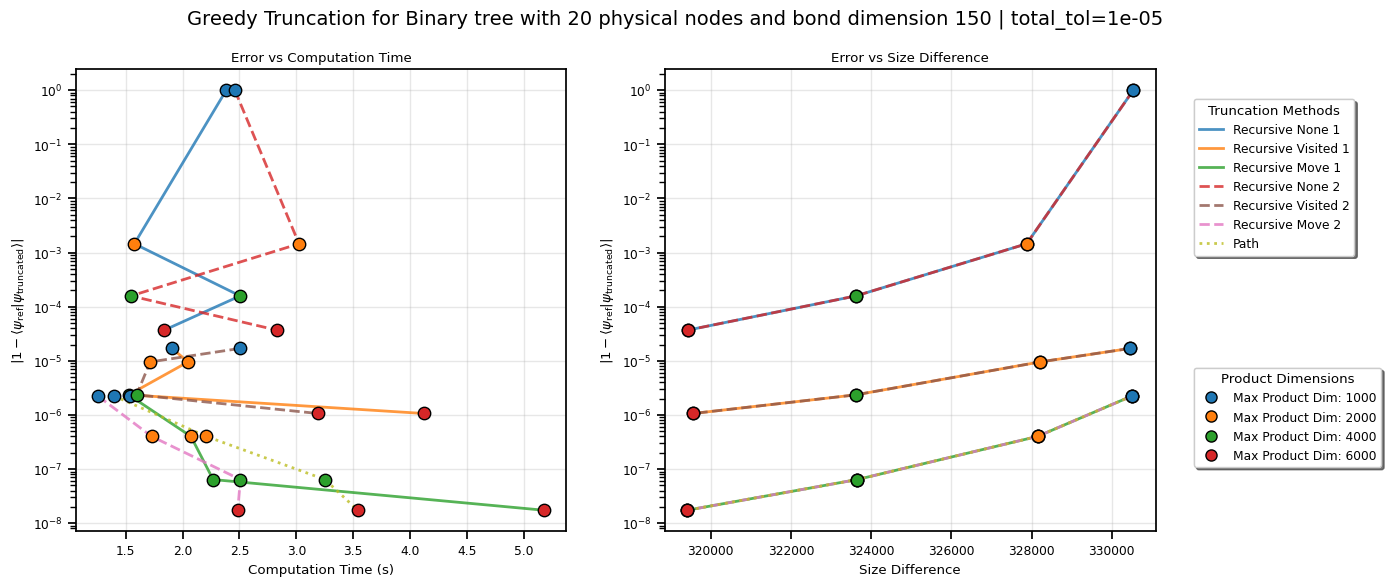

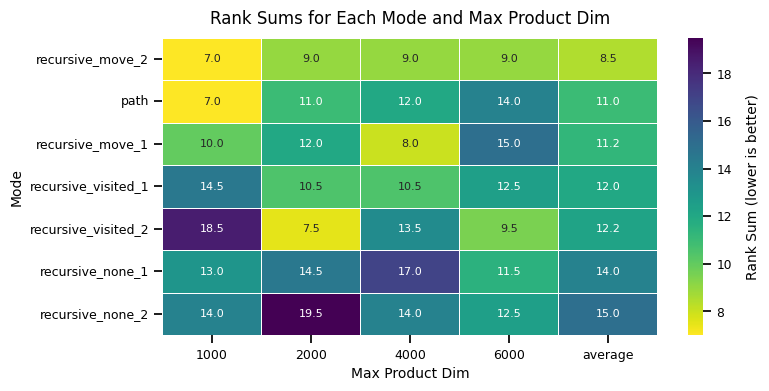

Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

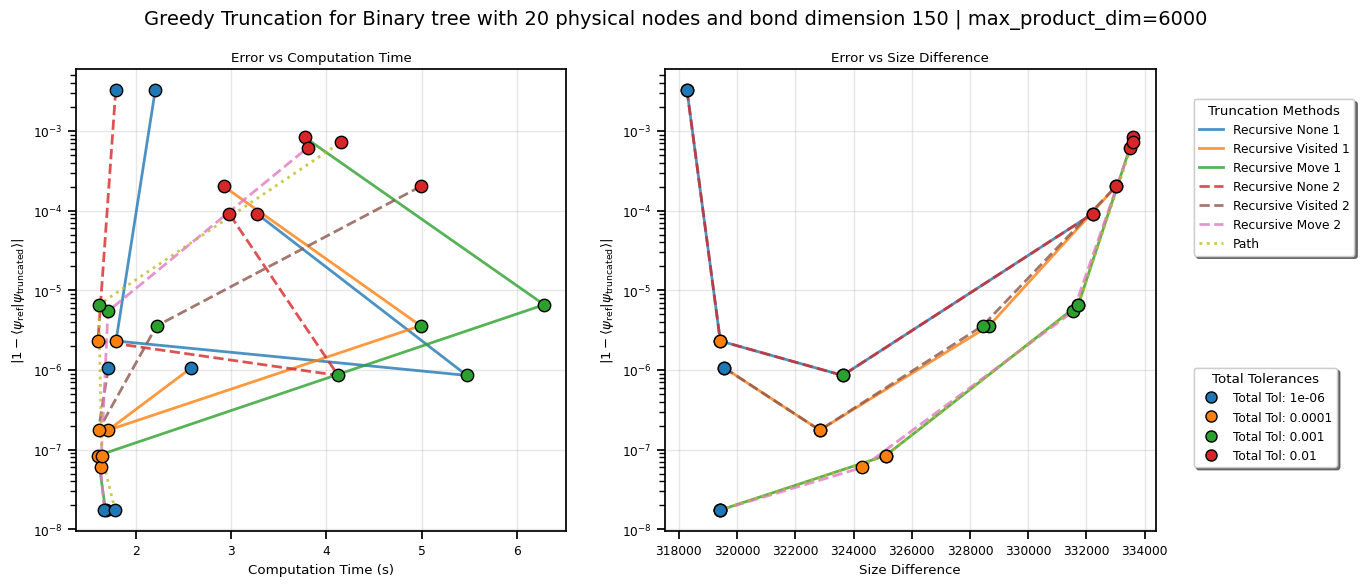

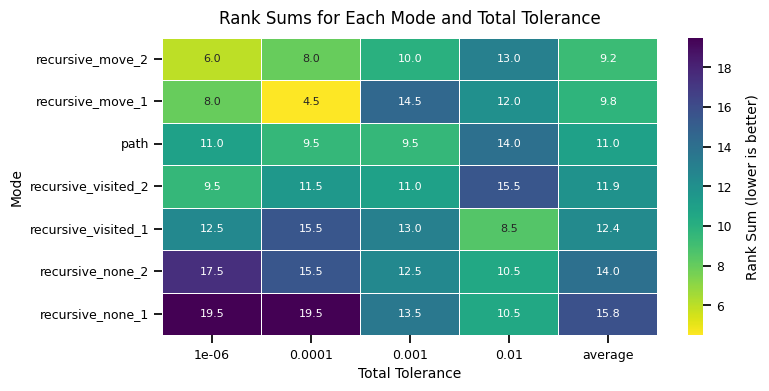

In [23]:
structure_name = "Binary tree"
num_phys = 20
bond_dim = 150
phys_tensor = np.array([1, 0], dtype=np.complex128)
binary_ttn = generate_binary_ttns(num_phys=num_phys, bond_dim=bond_dim, phys_tensor=phys_tensor)
binary_ttn = generate_random_ttn(binary_ttn,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=0.8)

# SVD parameters
max_product_dims = [1000, 2000, 4000, 6000]
total_tol = 1e-5
# RUN TRUNCATIONS
results = obtain_greedy_results_max_product_list(binary_ttn, trunc_modes, max_product_dims, total_tol)
# PLOT RESULTS
plot_greedy_results_max_product_list(results,title=(f"Greedy Truncation for {structure_name} with {num_phys} physical nodes"
                                                   f" and bond dimension {bond_dim} | total_tol={total_tol}"))
# SVD parameters
max_product_dim = 6000
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_greedy_results_total_tol_list(binary_ttn, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_greedy_results_total_tol_list(results,title=(f"Greedy Truncation for {structure_name} with {num_phys} physical nodes"
                                                   f" and bond dimension {bond_dim} | max_product_dim={max_product_dim}"))

## Cayley Tree Structure  

- **Physical sites** (`num_phys`): 10 - Smaller system with regular connectivity
- **Tree depth**: 4 levels - Balanced hierarchical structure
- **Bond dimension** (`bond_dim`): 150 - Initial bond dimensions before truncation  
- **Root bond dimension**: 150 - Specialized root connectivity for symmetric structure
- **Physical dimension**: 2 (binary degrees of freedom)


Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

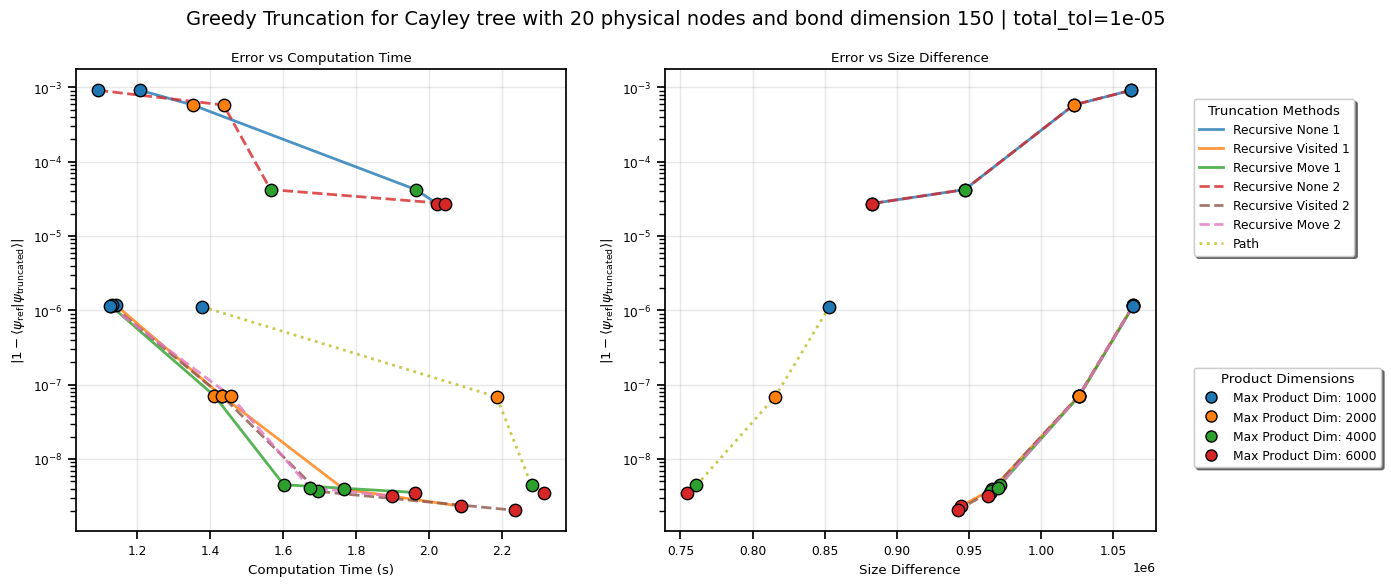

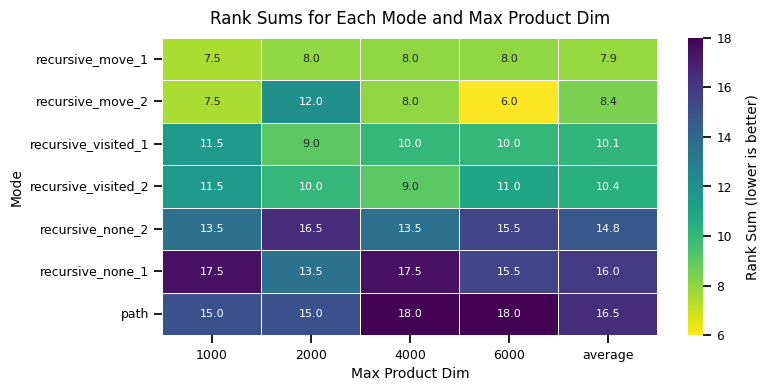

Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

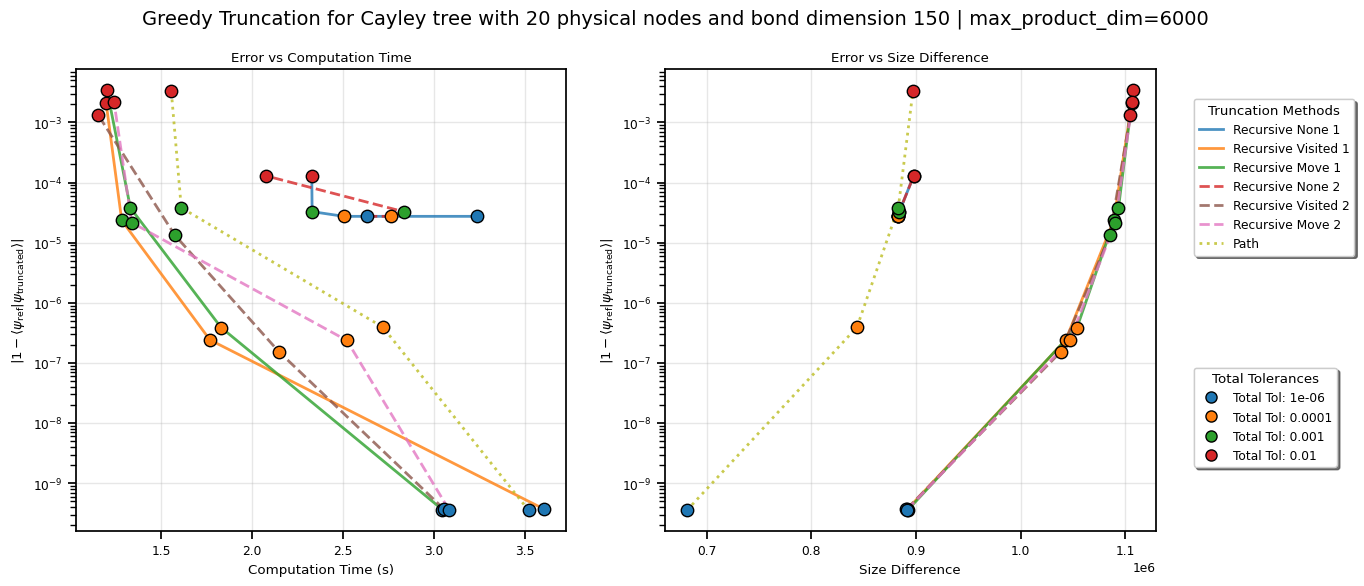

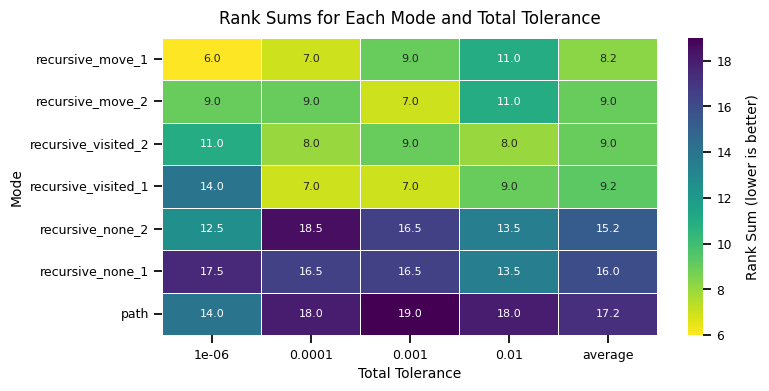

In [24]:
structure_name = "Cayley tree"
num_phys = 20
bond_dim = 150
phys_tensor = np.array([1, 0], dtype=np.complex128)
_, cayley_tree  = symmetric_ttndo_for_product_state(num_phys=num_phys, bond_dim=bond_dim, phys_tensor= phys_tensor)
cayley_tree = generate_random_ttn(cayley_tree,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=0.8)

# SVD parameters
max_product_dims = [1000, 2000, 4000, 6000]
total_tol = 1e-5
# RUN TRUNCATIONS
results = obtain_greedy_results_max_product_list(cayley_tree, trunc_modes, max_product_dims, total_tol)
# PLOT RESULTS
plot_greedy_results_max_product_list(results,title=(f"Greedy Truncation for {structure_name} with {num_phys} physical nodes"
                                                   f" and bond dimension {bond_dim} | total_tol={total_tol}"))
# SVD parameters
max_product_dim = 6000
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_greedy_results_total_tol_list(cayley_tree, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_greedy_results_total_tol_list(results,title=(f"Greedy Truncation for {structure_name} with {num_phys} physical nodes"
                                                   f" and bond dimension {bond_dim} | max_product_dim={max_product_dim}"))

## Fork Tree Structure

- **Width**: 5 - Number of parallel branches from central nodes
- **Height**: 6 - Depth of the fork structure  
- **Bond dimension** (`bond_dim`): 120 - Initial bond dimensions before truncation
- **Physical dimension**: 2 (binary state space)

Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

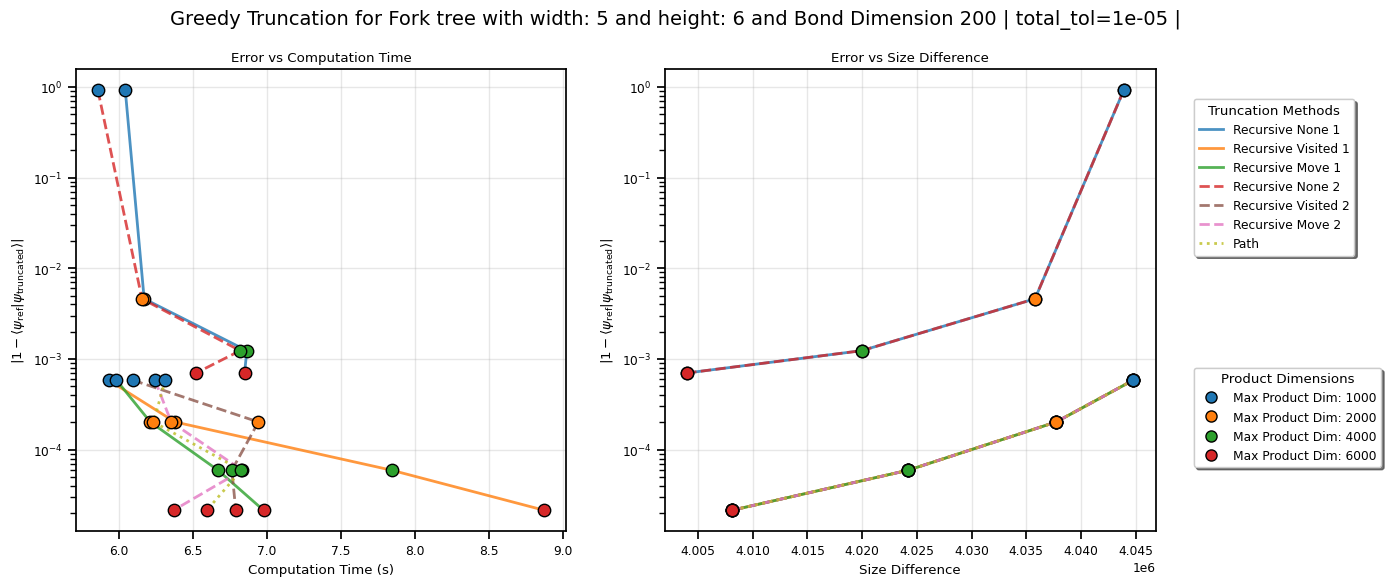

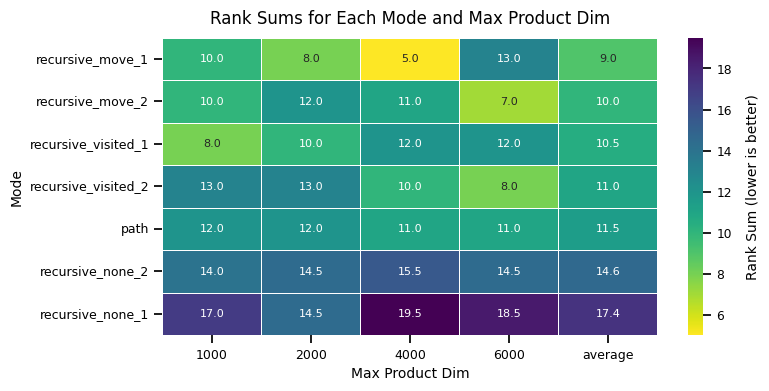

Running truncation tests:   0%|          | 0/28 [00:00<?, ?it/s]

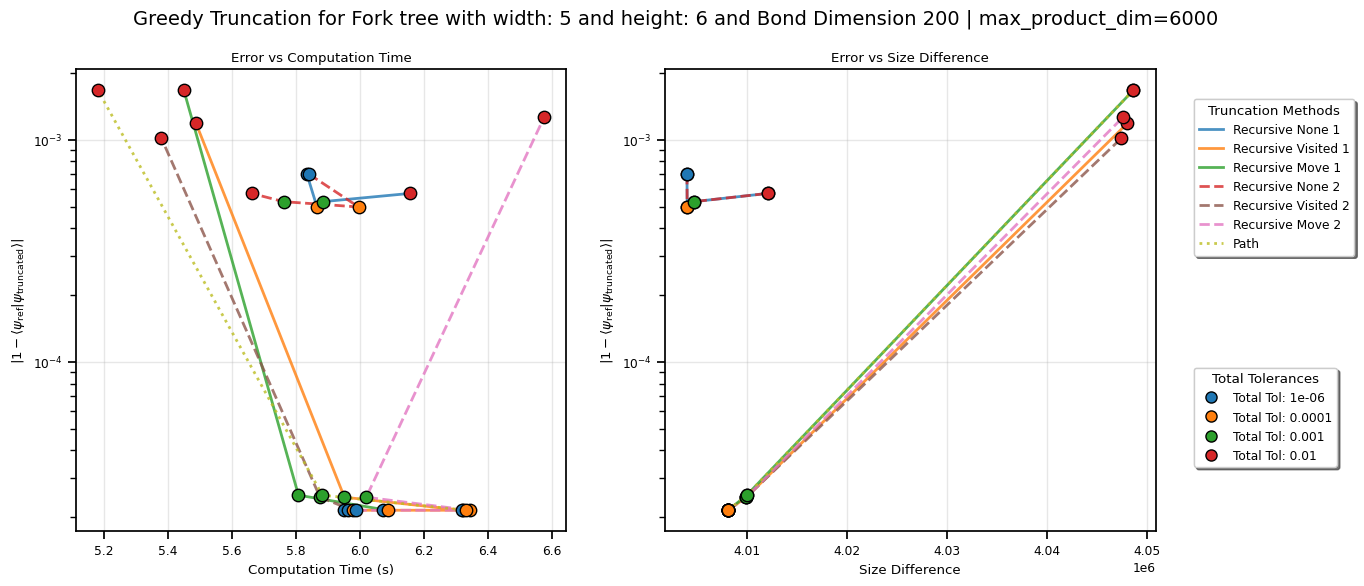

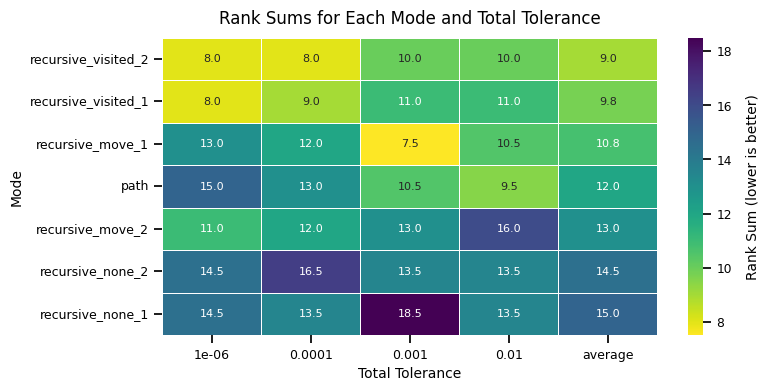

In [26]:
structure_name = "Fork tree"
width = 5
height = 6
bond_dim = 200
fork_ttn = constant_ftps(array([1, 0]), width, height, bond_dim)
fork_ttn = generate_random_ttn(fork_ttn,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=0.8)

# SVD parameters
max_product_dims = [1000, 2000, 4000, 6000]
total_tol = 1e-5
# RUN TRUNCATIONS
results = obtain_greedy_results_max_product_list(fork_ttn, trunc_modes, max_product_dims, total_tol)
# PLOT RESULTS
plot_greedy_results_max_product_list(results,title=(f"Greedy Truncation for {structure_name} with width: {width} "
                                                    f"and height: {height} and Bond Dimension {bond_dim} | "
                                                    f"total_tol={total_tol} |"))

# SVD parameters
max_product_dim = 6000
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_greedy_results_total_tol_list(fork_ttn, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_greedy_results_total_tol_list(results,title=(f"Greedy Truncation for {structure_name} with width: {width} "
                                                  f"and height: {height} and Bond Dimension {bond_dim} | "
                                                  f"max_product_dim={max_product_dim}"))

## Compare SVD truncation schemes

In [27]:
trunc_modes = [SVDTruncationMode.RECURSIVE_STATIC,
               SVDTruncationMode.RECURSIVE_DYNAMIC,
               SVDTruncationMode.PATH_LINEAR,
               SVDTruncationMode.PATH_OPTIMAL]

## Binary tree

Running truncation tests:   0%|          | 0/16 [00:00<?, ?it/s]

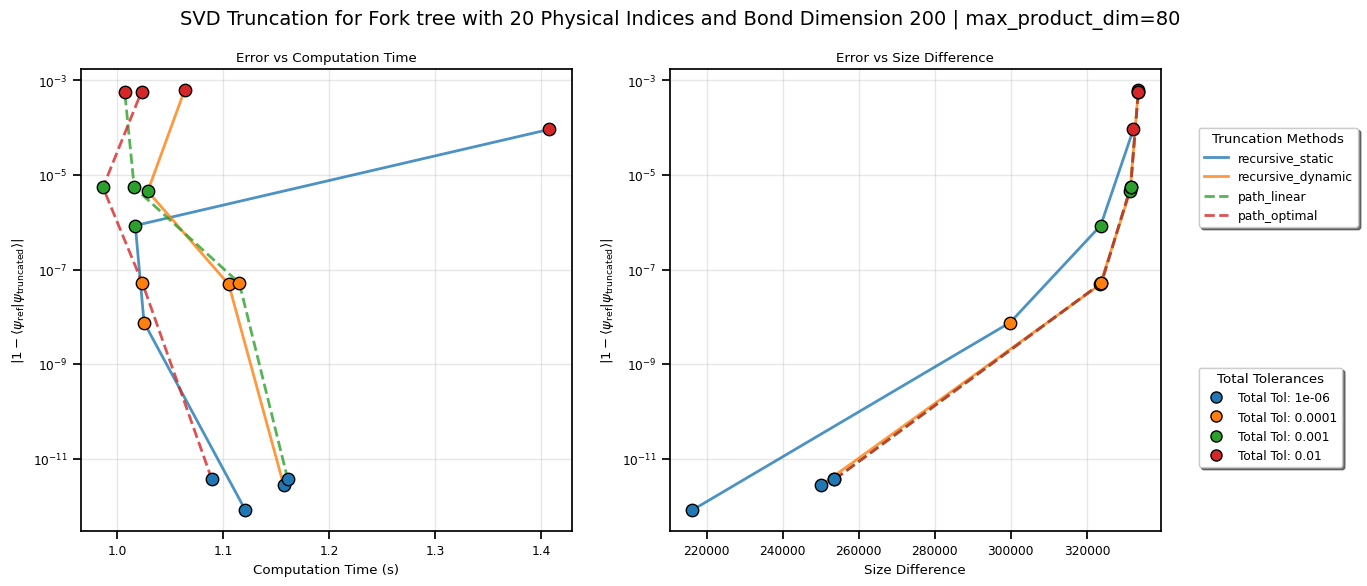

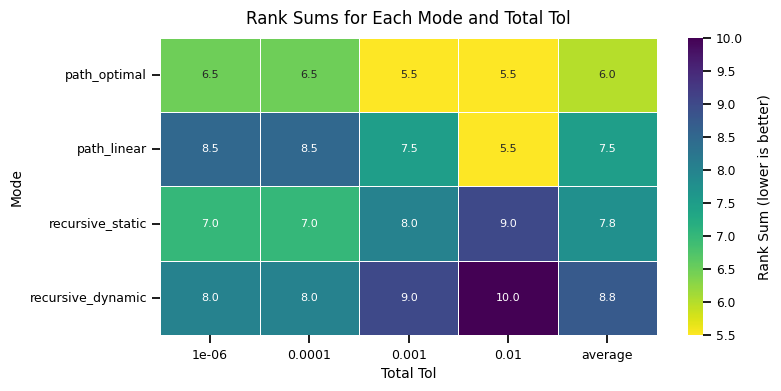

In [28]:
# SVD parameters
max_product_dim = 80
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_svd_results_total_tol_list(binary_ttn, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_svd_results_total_tol_list(results,title=(f"SVD Truncation for {structure_name} with {num_phys} "
                                              f"Physical Indices and Bond Dimension {bond_dim} | "
                                              f"max_product_dim={max_product_dim}"))

## Fork tree

Running truncation tests:   0%|          | 0/16 [00:00<?, ?it/s]

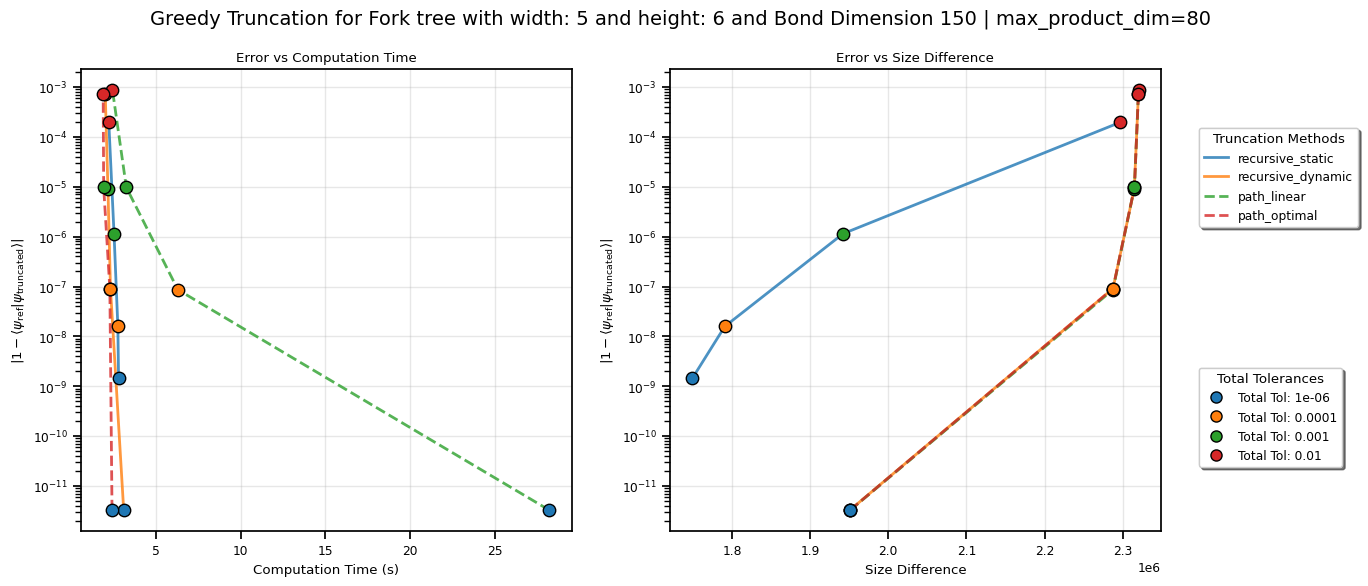

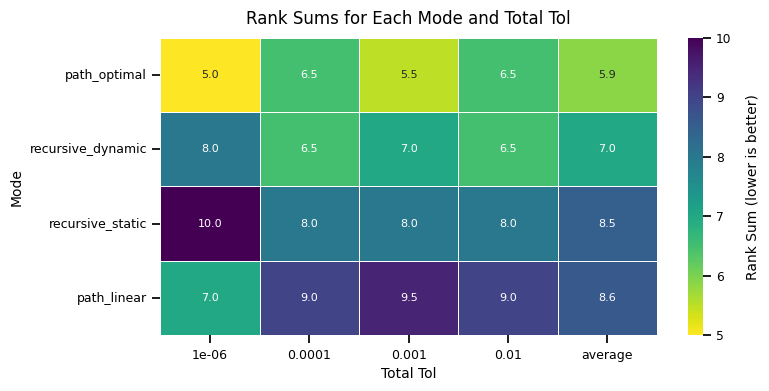

In [ ]:
# SVD parameters
max_product_dim = 80
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_svd_results_total_tol_list(fork_ttn, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_svd_results_total_tol_list(results,title=(f"Greedy Truncation for {structure_name} with width: {width} "
                                                  f"and height: {height} and Bond Dimension {bond_dim} | "
                                                  f"max_product_dim={max_product_dim}"))


## Cayley tree

Running truncation tests:   0%|          | 0/16 [00:00<?, ?it/s]

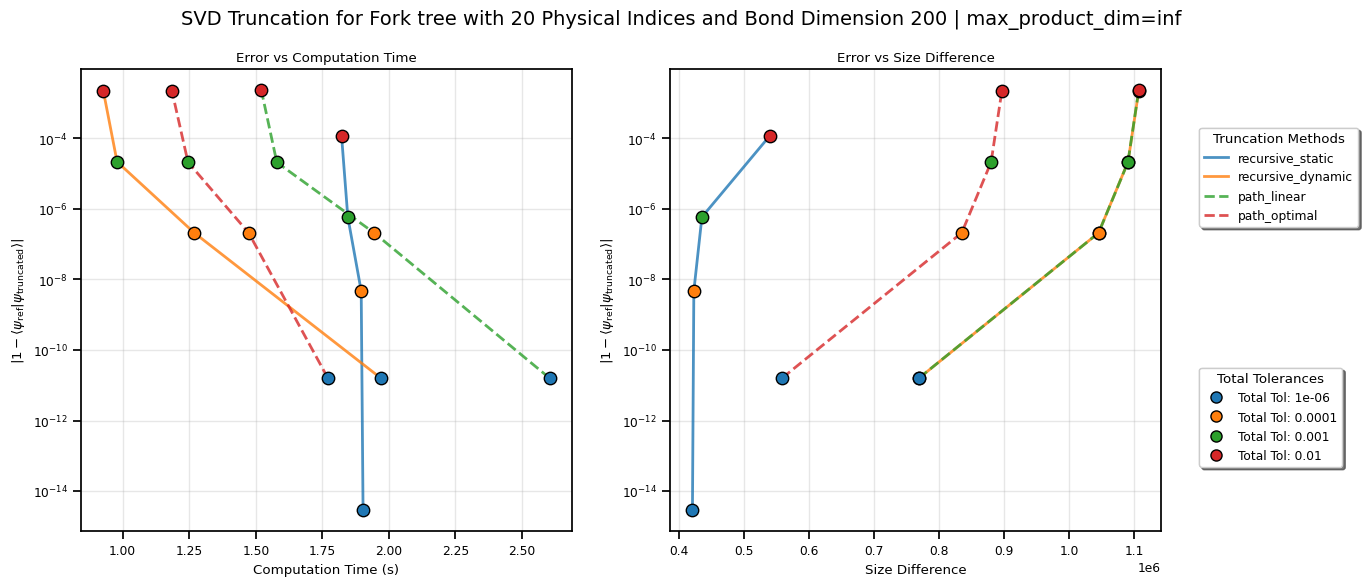

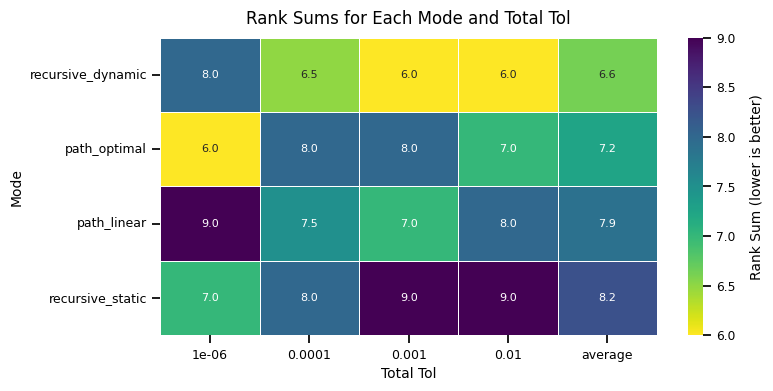

In [29]:
# SVD parameters
max_product_dim = float('inf')
total_tols = [1e-2 ,1e-3, 1e-4, 1e-6]
# RUN TRUNCATIONS
results = obtain_svd_results_total_tol_list(cayley_tree, trunc_modes, total_tols, max_product_dim)
# PLOT RESULTS
plot_svd_results_total_tol_list(results,title=(f"SVD Truncation for {structure_name} with {num_phys} "
                                              f"Physical Indices and Bond Dimension {bond_dim} | "
                                              f"max_product_dim={max_product_dim}"))

## Greedy vs SVD truncations

In [30]:
greedy_modes = [GreedyTruncationMode.RECURSIVE_MOVE_1,
                GreedyTruncationMode.PATH]
svd_modes = [SVDTruncationMode.RECURSIVE_DYNAMIC,
             SVDTruncationMode.PATH_OPTIMAL]


## Binary tree

Running greedy vs SVD comparison:   0%|          | 0/24 [00:00<?, ?it/s]

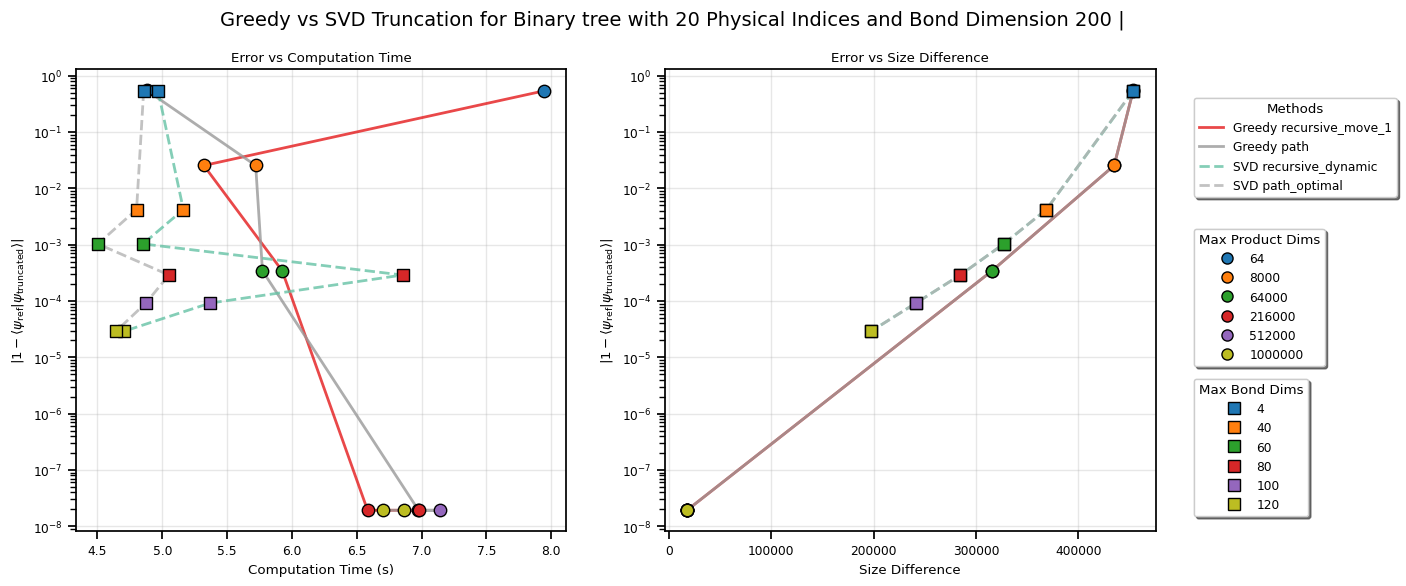

In [32]:
structure_name = "Binary tree"
num_phys = 20
bond_dim = 200
phys_tensor = np.array([1, 0], dtype=np.complex128)
binary_ttn = generate_binary_ttns(num_phys=num_phys, bond_dim=bond_dim, phys_tensor=phys_tensor)
binary_ttn = generate_random_ttn(binary_ttn,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=0.2)

max_bond_dims = [4, 40, 60, 80, 100, 120]
max_product_dims = [(4)**3, (20)**3, (40)**3, (60)**3, (80)**3, (100)**3]  

results = obtain_greedy_vs_svd_results(binary_ttn, greedy_modes, svd_modes, max_product_dims, max_bond_dims)
plot_greedy_vs_svd_results(results,
                           title=(f"Greedy vs SVD Truncation for {structure_name} with {num_phys} "
                                  f"Physical Indices and Bond Dimension {bond_dim} | "))

# Fork tree

Running greedy vs SVD comparison:   0%|          | 0/24 [00:00<?, ?it/s]

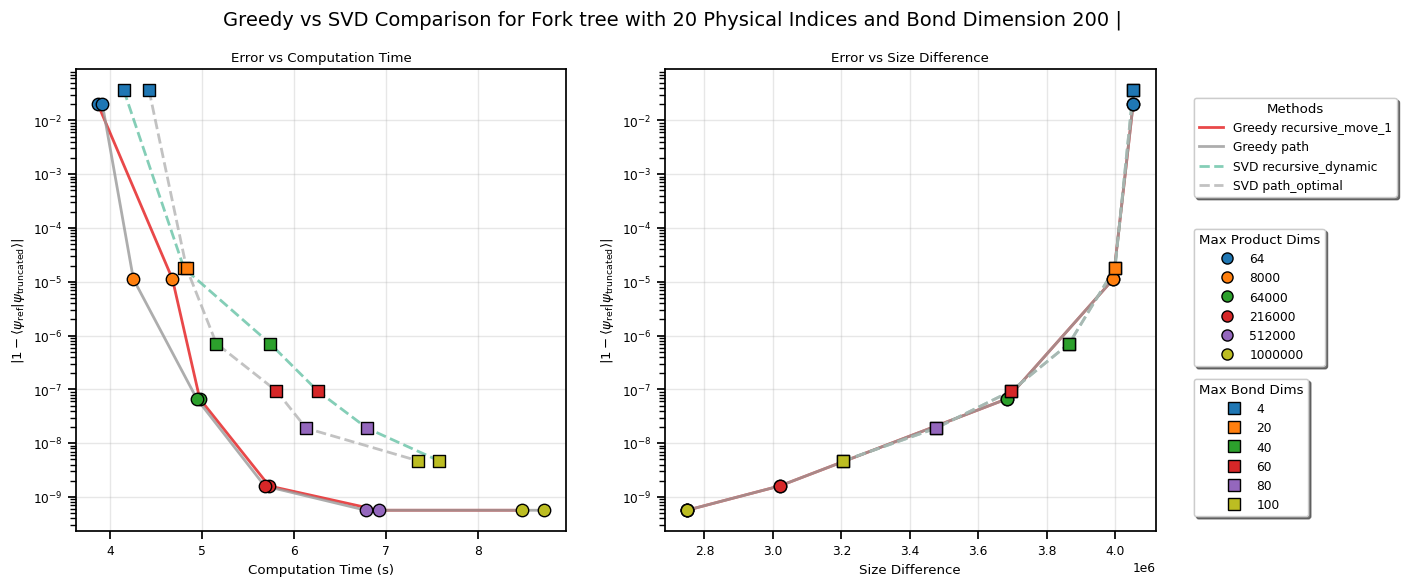

In [38]:
structure_name = "Fork tree"


max_bond_dims = [4, 20, 40, 60, 80, 100]
max_product_dims = [(4)**3, (20)**3, (40)**3, (60)**3, (80)**3, (100)**3]  

results = obtain_greedy_vs_svd_results(fork_ttn, greedy_modes, svd_modes,
                                       max_product_dims, max_bond_dims, total_tol)

plot_greedy_vs_svd_results(results,
                          title=(f"Greedy vs SVD Comparison for {structure_name} with {num_phys} "
                                f"Physical Indices and Bond Dimension {bond_dim} | "))

# Cayley tree

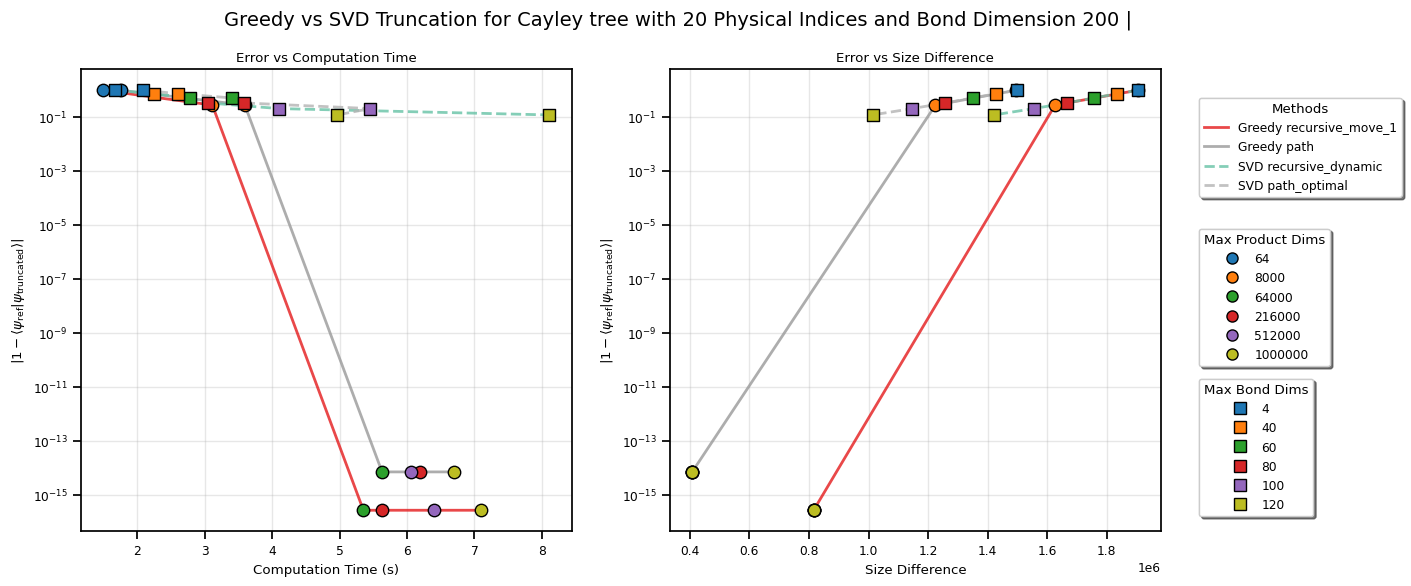

In [37]:
structure_name = "Cayley tree"
num_phys = 20
bond_dim = 200
phys_tensor = np.array([1, 0], dtype=np.complex128)
_, cayley_tree  = symmetric_ttndo_for_product_state(num_phys=num_phys, bond_dim=bond_dim, phys_tensor= phys_tensor)
cayley_tree = generate_random_ttn(cayley_tree,
                                large_scale=10,
                                small_scale=1e-8,
                                decay_rate=0.2)

max_bond_dims = [4, 40, 60, 80, 100, 120]
max_product_dims = [(4)**3, (20)**3, (40)**3, (60)**3, (80)**3, (100)**3]   

results = obtain_greedy_vs_svd_results(cayley_tree, greedy_modes, svd_modes, max_product_dims, max_bond_dims)
plot_greedy_vs_svd_results(results,
                           title=(f"Greedy vs SVD Truncation for {structure_name} with {num_phys} "
                                  f"Physical Indices and Bond Dimension {bond_dim} | "))